# Laboratorio Sesión 17: Análisis de Clustering para Detección de Anomalías en Pozos Petroleros

En este laboratorio aplicaremos técnicas de clustering no supervisado (KMeans y DBSCAN) para detectar anomalías en datos operacionales de pozos petroleros. El objetivo es identificar patrones anómalos en el comportamiento de los pozos que puedan indicar fallas en equipos, bloqueos, corrosión u otros problemas operacionales.

## Objetivos del Laboratorio:

1. **Análisis Exploratorio (EDA)**: Entender la distribución de variables y detectar outliers
2. **Ingeniería de Features**: Crear variables derivadas relevantes para el dominio petrolero
3. **Clustering con KMeans**: Encontrar grupos operacionales y detectar anomalías
4. **Clustering con DBSCAN**: Identificar puntos de baja densidad como anomalías
5. **Evaluación y Comparación**: Usar métricas cuantitativas para comparar métodos

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías para clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import classification_report, confusion_matrix

# Librerías para visualización
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


## 1. Carga de Datos y Análisis Inicial

Cargaremos el dataset de anomalías petroleras y realizaremos un análisis inicial de la estructura de los datos.

In [4]:
# Cargar datos
df = pd.read_csv('/workspaces/ml-bootcamp-labs/data/raw/dataset_oil_anomalies_v2.csv')

# Información básica del dataset
print("Forma del dataset:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())

Forma del dataset: (10000, 22)

Primeras 5 filas:
             timestamp   well_id  pressure_psi     temp_c  flow_rate_bpd  \
0  2025-08-19 18:11:19  well_018    250.082299  92.521188    1016.814290   
1  2025-08-15 01:16:53  well_042    268.199733  90.668913     865.355848   
2  2025-08-06 04:38:39  well_008    253.673926  71.254269    1129.922530   
3  2025-08-15 05:27:28  well_015    315.963308  89.765747     582.884803   
4  2025-08-14 13:32:39  well_010    263.966579  78.057341    1076.776600   

   vibration_g  pump_speed_rpm  oil_quality  gas_oil_ratio  \
0     0.750688      986.152015     0.800602     270.893285   
1     0.839681     1305.981627     0.920880     268.879604   
2     0.980357     1377.435303     0.817536     101.958136   
3     0.670319     1515.506721     0.777645     228.983989   
4     1.140038     1254.622643     0.741505      76.032773   

   valve_position_pct  annulus_pressure_psi  pump_efficiency  tubing_temp_c  \
0           80.112531             54.8536

In [5]:
# Información sobre tipos y valores faltantes
print("\nInfo del dataset:")
df.info()



Info del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               10000 non-null  object 
 1   well_id                 10000 non-null  object 
 2   pressure_psi            10000 non-null  float64
 3   temp_c                  10000 non-null  float64
 4   flow_rate_bpd           10000 non-null  float64
 5   vibration_g             10000 non-null  float64
 6   pump_speed_rpm          10000 non-null  float64
 7   oil_quality             10000 non-null  float64
 8   gas_oil_ratio           10000 non-null  float64
 9   valve_position_pct      10000 non-null  float64
 10  annulus_pressure_psi    10000 non-null  float64
 11  pump_efficiency         10000 non-null  float64
 12  tubing_temp_c           10000 non-null  float64
 13  water_injection_bpd     10000 non-null  float64
 14  h2s_ppm             

In [6]:

# Estadísticas básicas
print("\nEstadísticas descriptivas:")
print(df.describe())


Estadísticas descriptivas:
       pressure_psi        temp_c  flow_rate_bpd   vibration_g  \
count  10000.000000  10000.000000   10000.000000  10000.000000   
mean     297.932725     77.448420     846.778428      1.595035   
std       39.895926     10.847090     189.506678      0.672661   
min     -269.477183     39.879014     101.419649      0.144070   
25%      268.791282     66.883835     697.139096      1.006625   
50%      301.553186     79.752517     876.242251      1.673695   
75%      326.255289     86.157359    1002.504455      2.147094   
max      878.541530    119.187503    1233.552302      6.593377   

       pump_speed_rpm   oil_quality  gas_oil_ratio  valve_position_pct  \
count    10000.000000  10000.000000   10000.000000        10000.000000   
mean      1285.726243      0.837536     187.825940           80.004954   
std        285.053391      0.092440      83.444185            4.978499   
min        363.306219      0.191649      33.844891           61.403990   
25%    

In [7]:
# Análisis de valores faltantes
print("Valores faltantes por columna:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
}).sort_values('Porcentaje', ascending=False)

print(missing_df[missing_df['Valores_Faltantes'] > 0])

# Distribución de anomalías
print("\n" + "="*50)
print("DISTRIBUCIÓN DE ANOMALÍAS")
print("="*50)

print("\nDistribución de anomaly_label:")
print(df['anomaly_label'].value_counts())
print(f"\nPorcentaje de anomalías: {(df['anomaly_label'].sum() / len(df) * 100):.2f}%")

print("\nDistribución de anomaly_type:")
print(df['anomaly_type'].value_counts())

print("\nDistribución de severity:")
print(df['severity'].value_counts())

Valores faltantes por columna:
Empty DataFrame
Columns: [Columna, Valores_Faltantes, Porcentaje]
Index: []

DISTRIBUCIÓN DE ANOMALÍAS

Distribución de anomaly_label:
anomaly_label
0    9700
1     300
Name: count, dtype: int64

Porcentaje de anomalías: 3.00%

Distribución de anomaly_type:
anomaly_type
normal              9700
blockage              57
gas_breakthrough      55
leak                  54
corrosion             48
pump_failure          43
sensor_fault          43
Name: count, dtype: int64

Distribución de severity:
severity
0.000    9700
0.255       4
0.104       3
0.110       3
0.057       3
         ... 
0.618       1
0.011       1
0.380       1
0.392       1
0.182       1
Name: count, Length: 230, dtype: int64


## 2. Análisis Exploratorio de Datos (EDA)

### 2.1 Visualizaciones Iniciales - Histogramas y Distribuciones

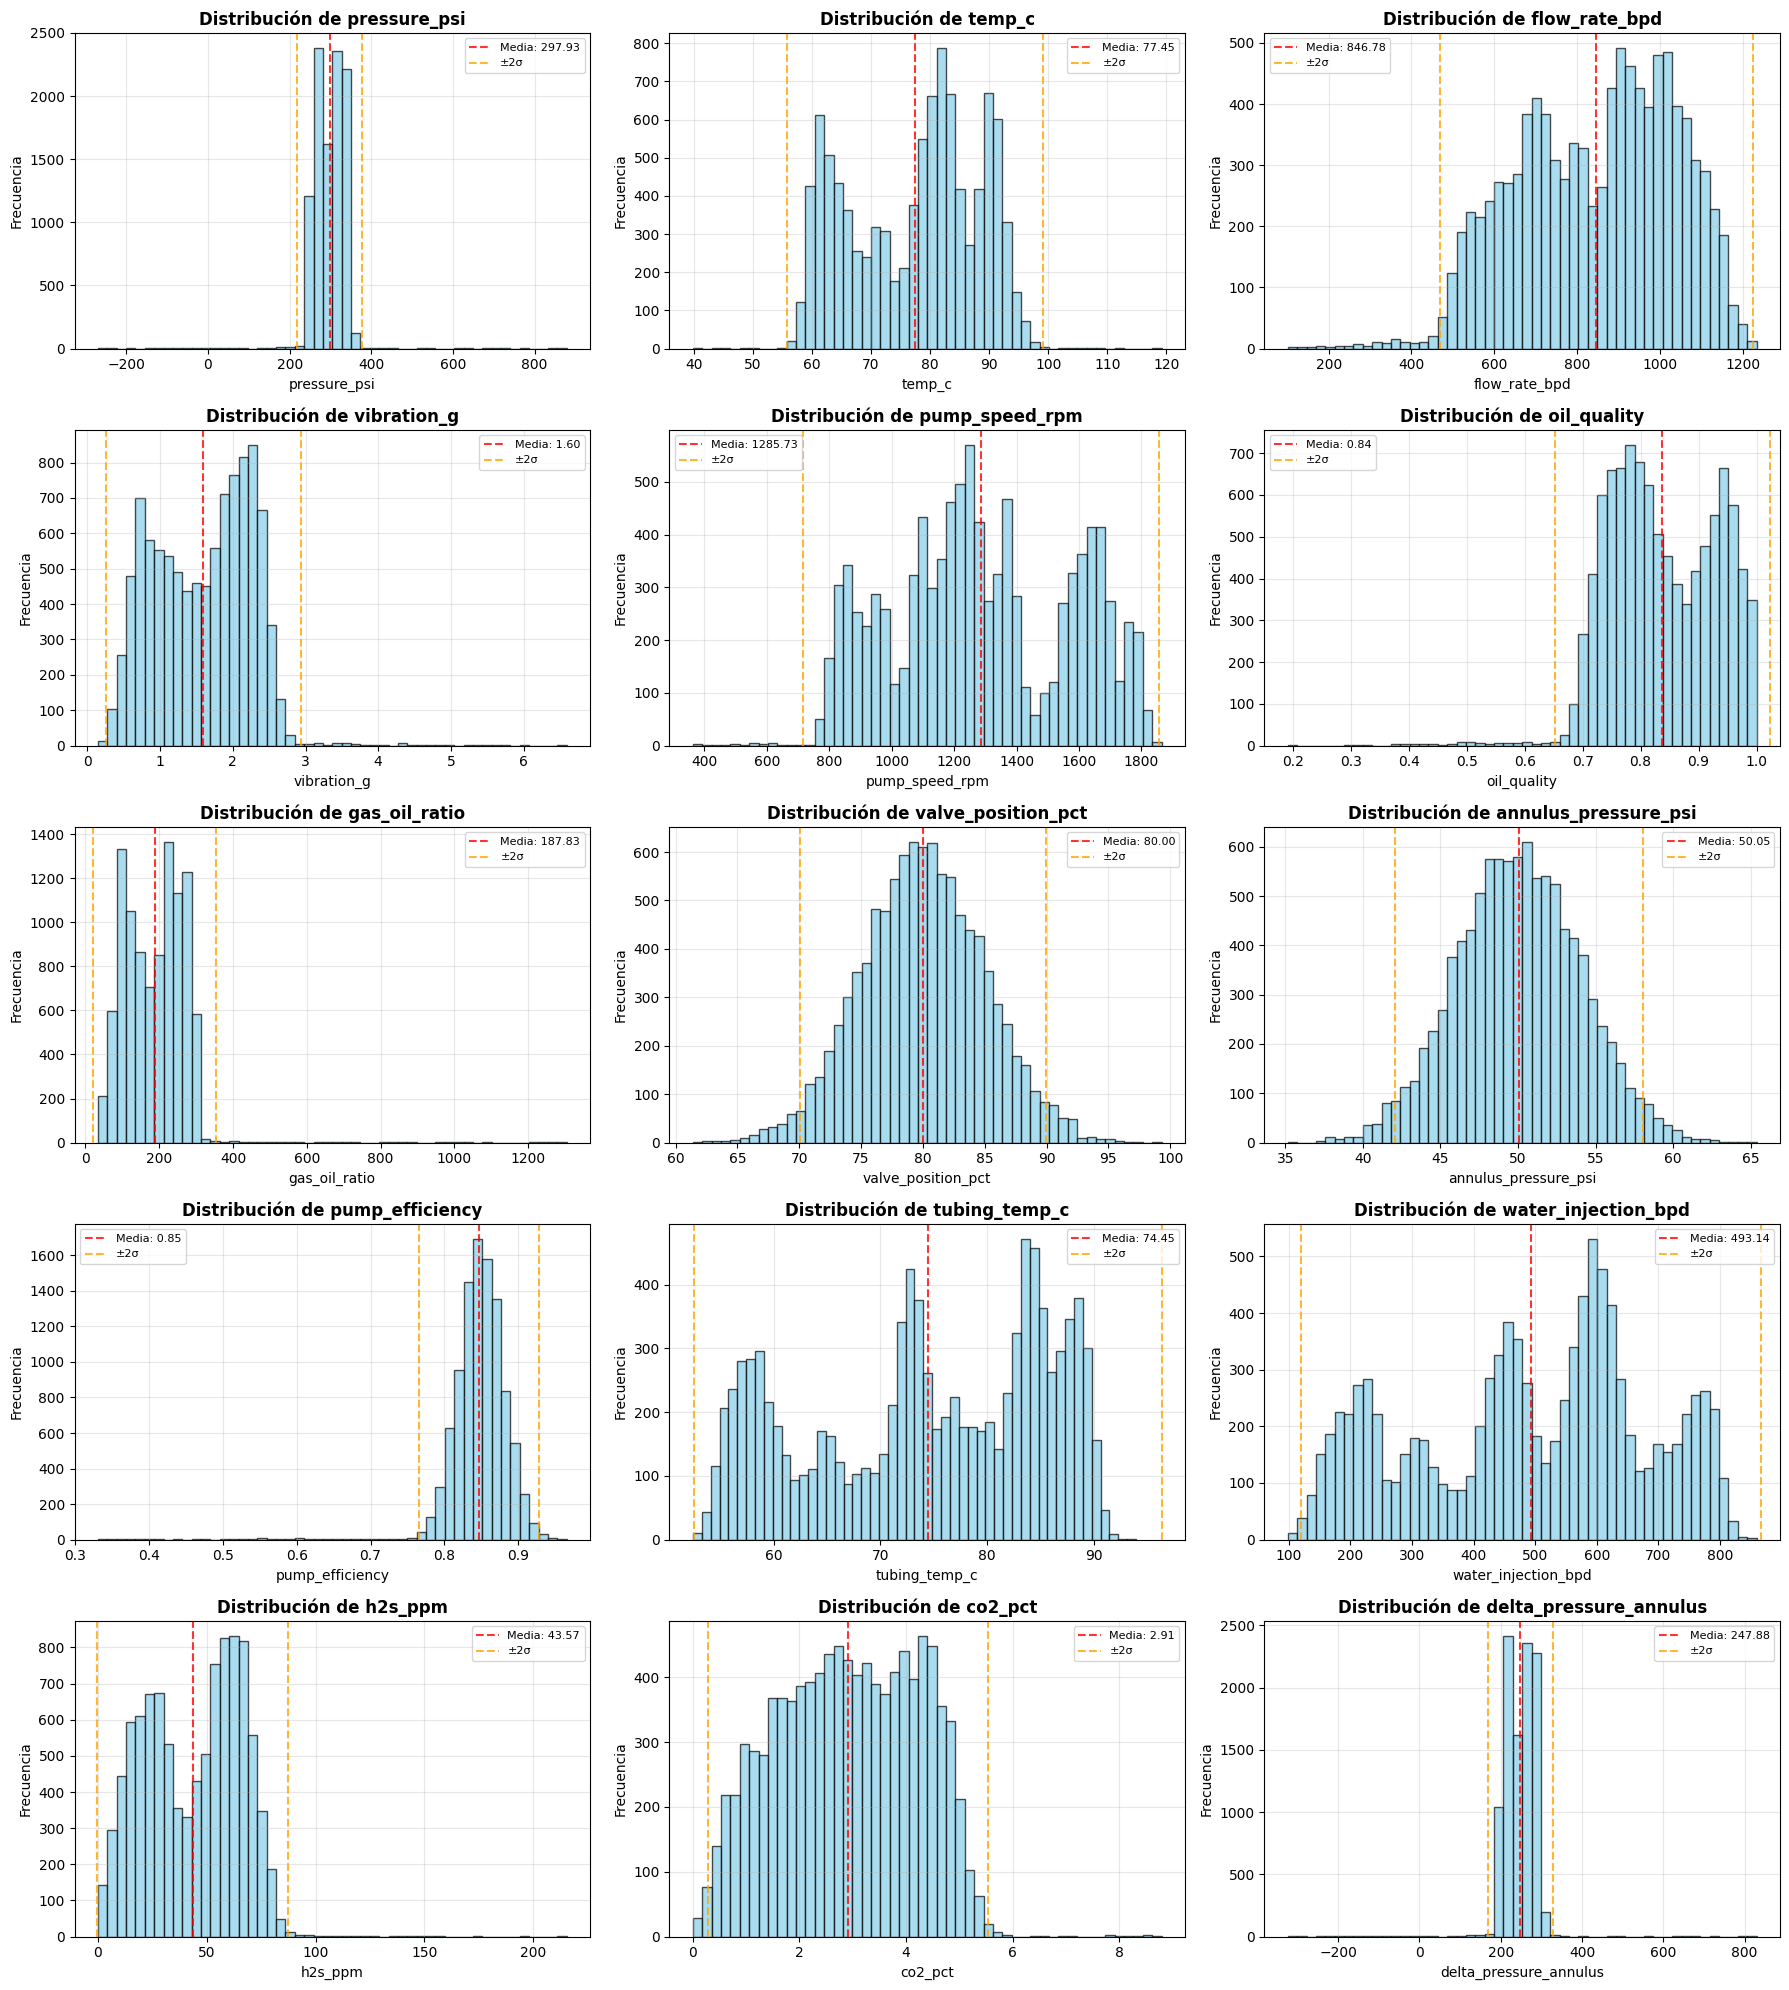

ANÁLISIS DE OUTLIERS (valores fuera de ±2σ):
pressure_psi: 80 outliers (0.80%)
temp_c: 19 outliers (0.19%)
flow_rate_bpd: 126 outliers (1.26%)
vibration_g: 78 outliers (0.78%)
pump_speed_rpm: 31 outliers (0.31%)
oil_quality: 94 outliers (0.94%)
gas_oil_ratio: 53 outliers (0.53%)
valve_position_pct: 477 outliers (4.77%)
annulus_pressure_psi: 476 outliers (4.76%)
pump_efficiency: 153 outliers (1.53%)
tubing_temp_c: 3 outliers (0.03%)
water_injection_bpd: 19 outliers (0.19%)
h2s_ppm: 35 outliers (0.35%)
co2_pct: 96 outliers (0.96%)
delta_pressure_annulus: 78 outliers (0.78%)


In [8]:
# Seleccionar variables numéricas principales para análisis
numerical_vars = ['pressure_psi', 'temp_c', 'flow_rate_bpd', 'vibration_g', 
                  'pump_speed_rpm', 'oil_quality', 'gas_oil_ratio', 
                  'valve_position_pct', 'annulus_pressure_psi', 'pump_efficiency',
                  'tubing_temp_c', 'water_injection_bpd', 'h2s_ppm', 'co2_pct',
                  'delta_pressure_annulus']

# Crear histogramas para todas las variables numéricas
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.ravel()

for i, var in enumerate(numerical_vars):
    # Histograma general
    axes[i].hist(df[var], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribución de {var}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)
    
    # Agregar estadísticas básicas
    mean_val = df[var].mean()
    std_val = df[var].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.2f}')
    axes[i].axvline(mean_val + 2*std_val, color='orange', linestyle='--', alpha=0.8, label='±2σ')
    axes[i].axvline(mean_val - 2*std_val, color='orange', linestyle='--', alpha=0.8)
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Estadísticas de outliers
print("ANÁLISIS DE OUTLIERS (valores fuera de ±2σ):")
print("=" * 50)
for var in numerical_vars:
    mean_val = df[var].mean()
    std_val = df[var].std()
    outliers = df[(df[var] < mean_val - 2*std_val) | (df[var] > mean_val + 2*std_val)]
    pct_outliers = (len(outliers) / len(df)) * 100
    print(f"{var}: {len(outliers)} outliers ({pct_outliers:.2f}%)")

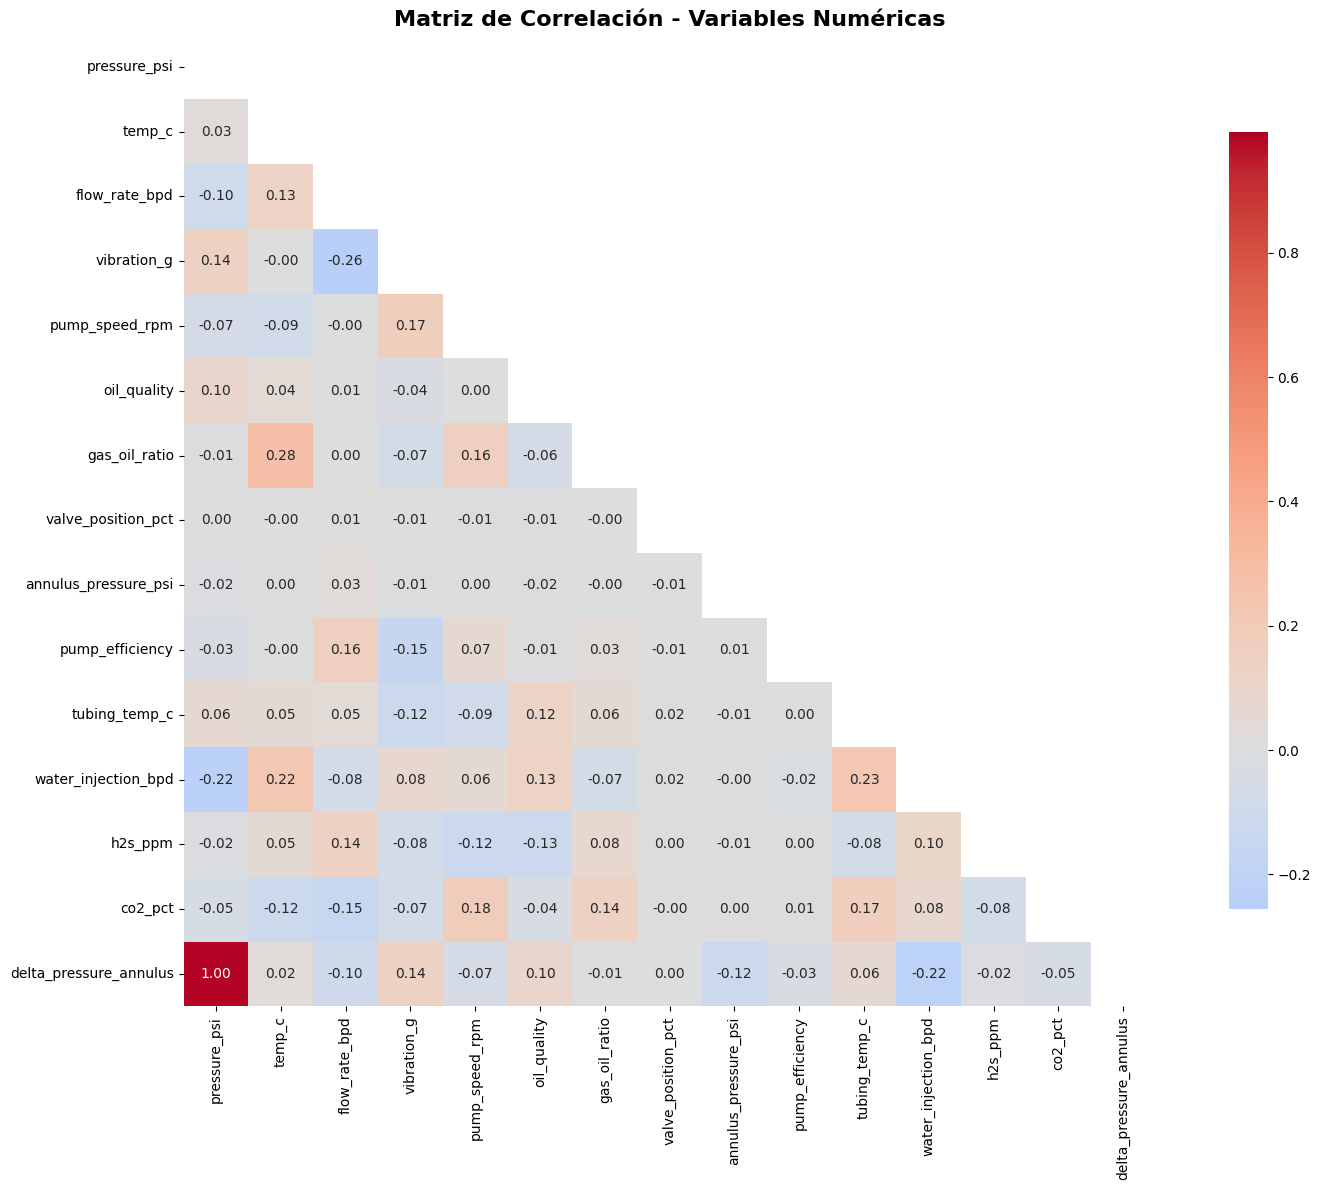

Pares de variables con correlación > 0.7:
pressure_psi - delta_pressure_annulus: 0.995


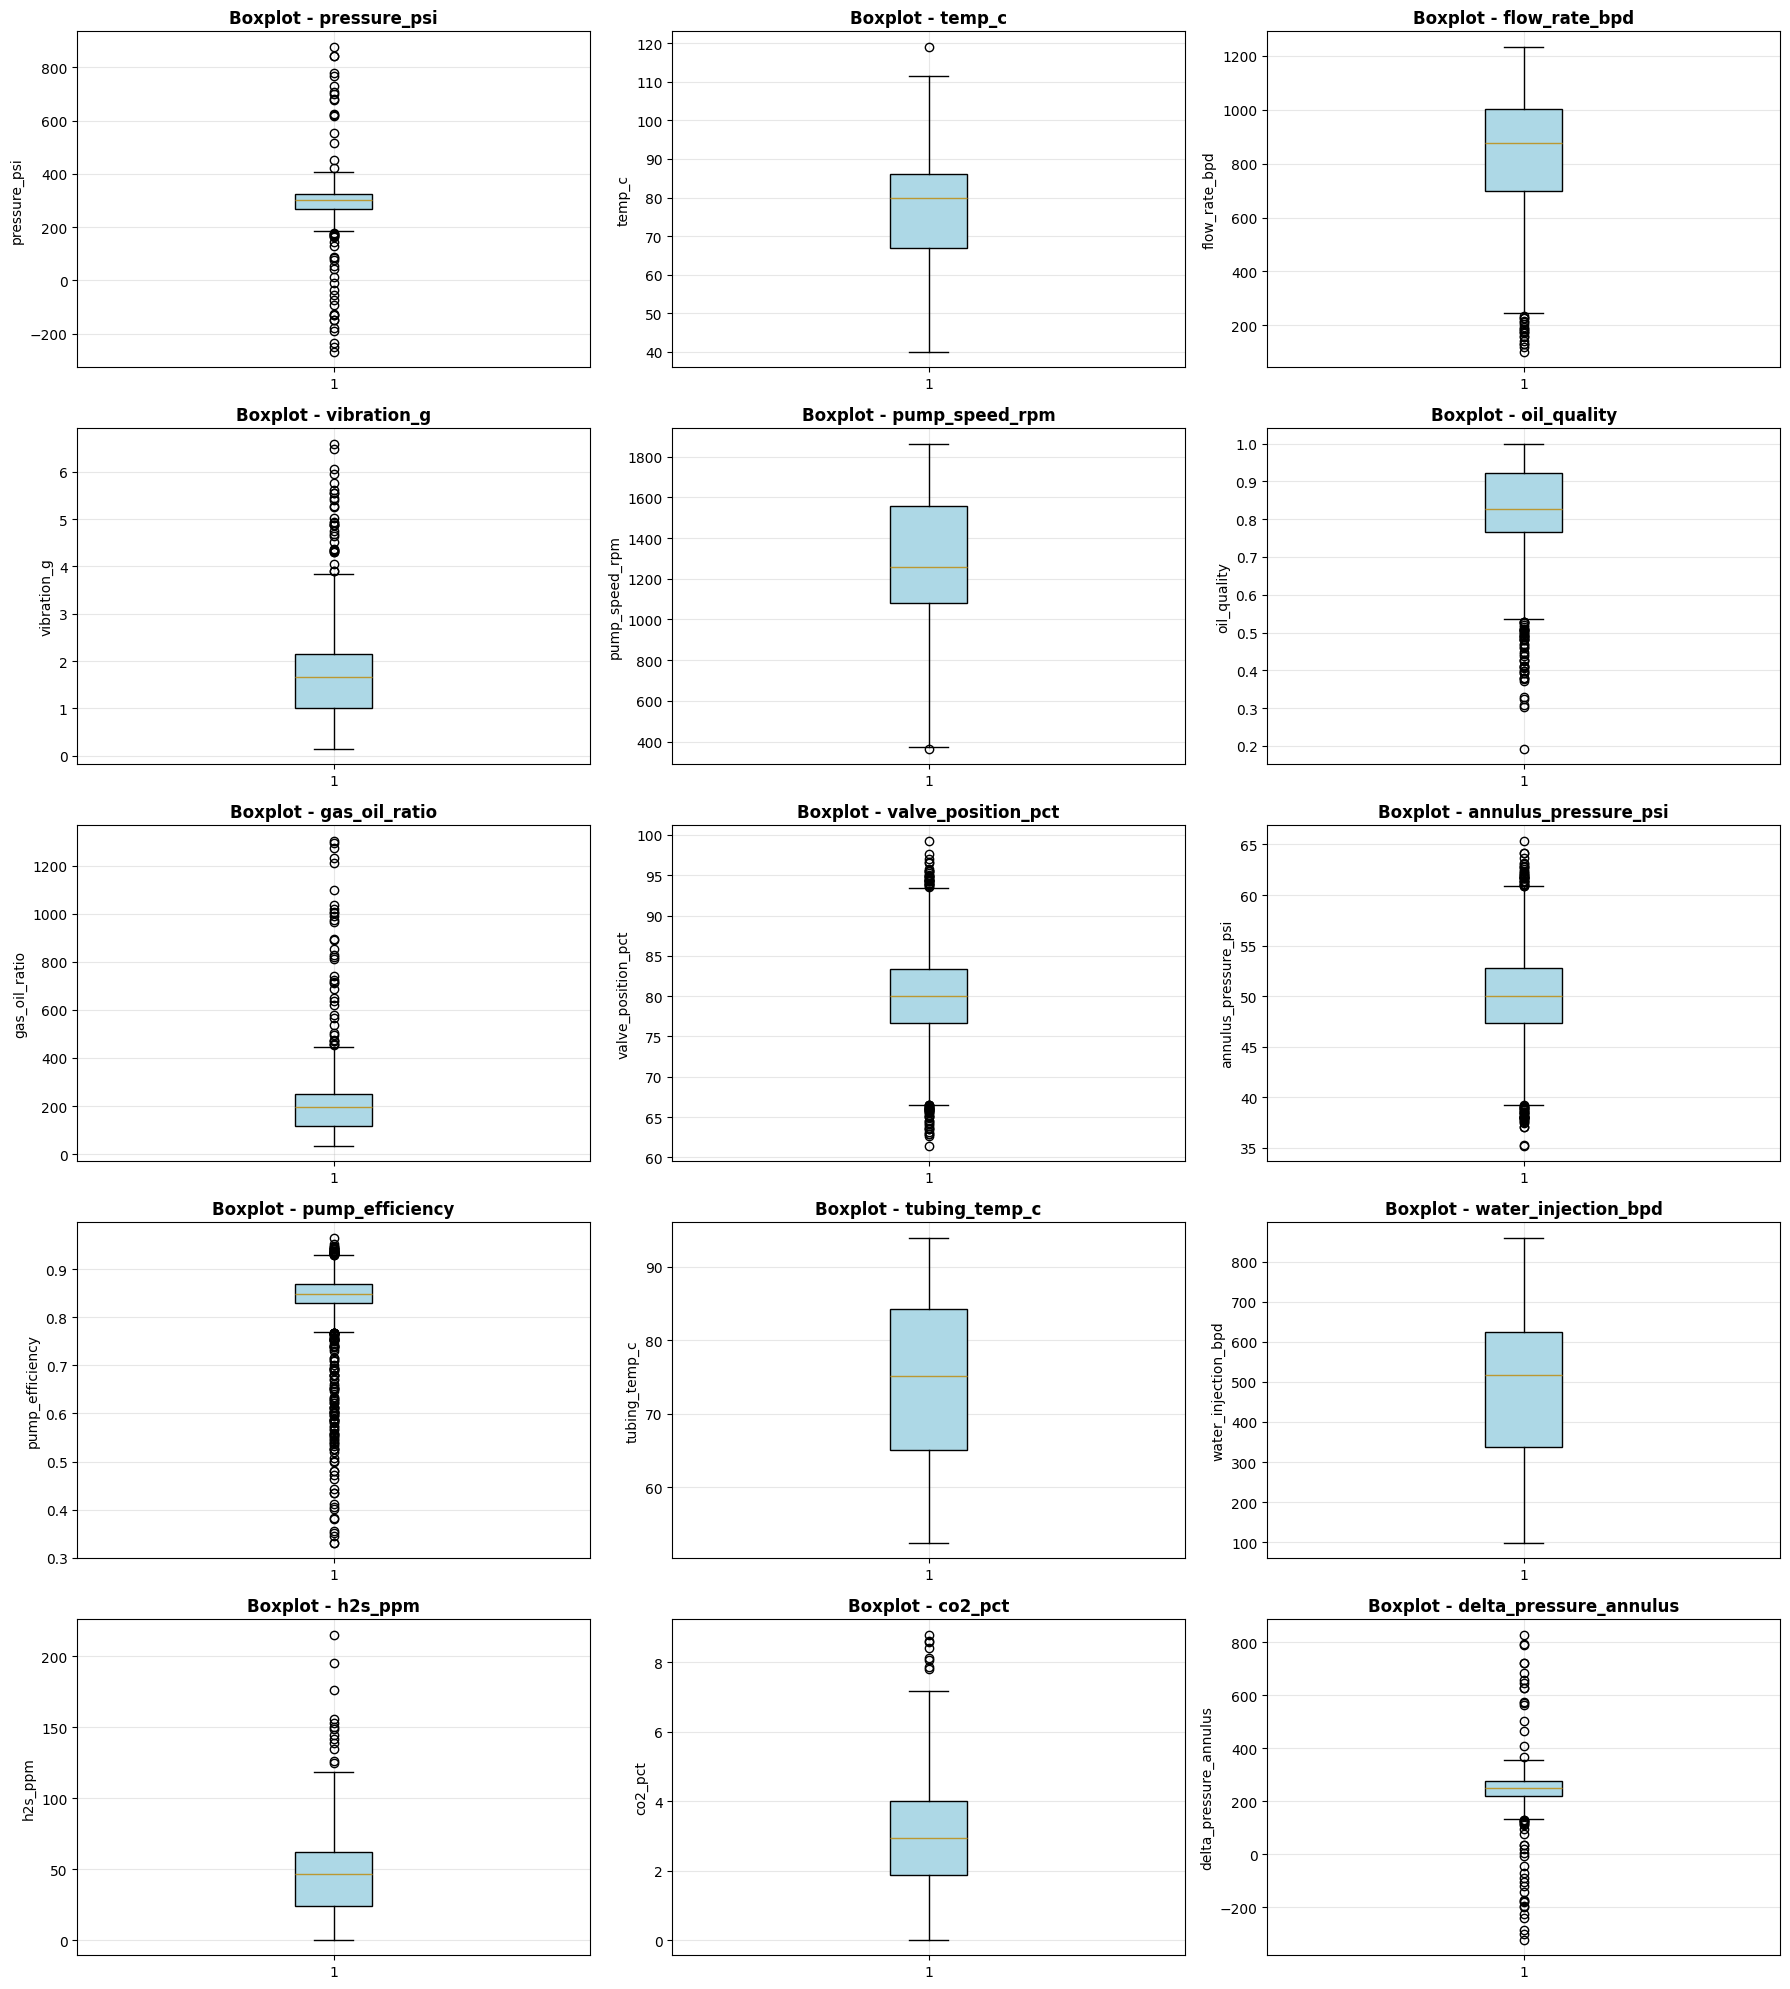

In [9]:
# Matriz de correlación
plt.figure(figsize=(16, 12))
correlation_matrix = df[numerical_vars].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Identificar variables altamente correlacionadas
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                  correlation_matrix.columns[j], 
                                  corr_val))

print("Pares de variables con correlación > 0.7:")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")

# Boxplots para detectar outliers
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.ravel()

for i, var in enumerate(numerical_vars):
    box = axes[i].boxplot(df[var], patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    axes[i].set_title(f'Boxplot - {var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(var)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

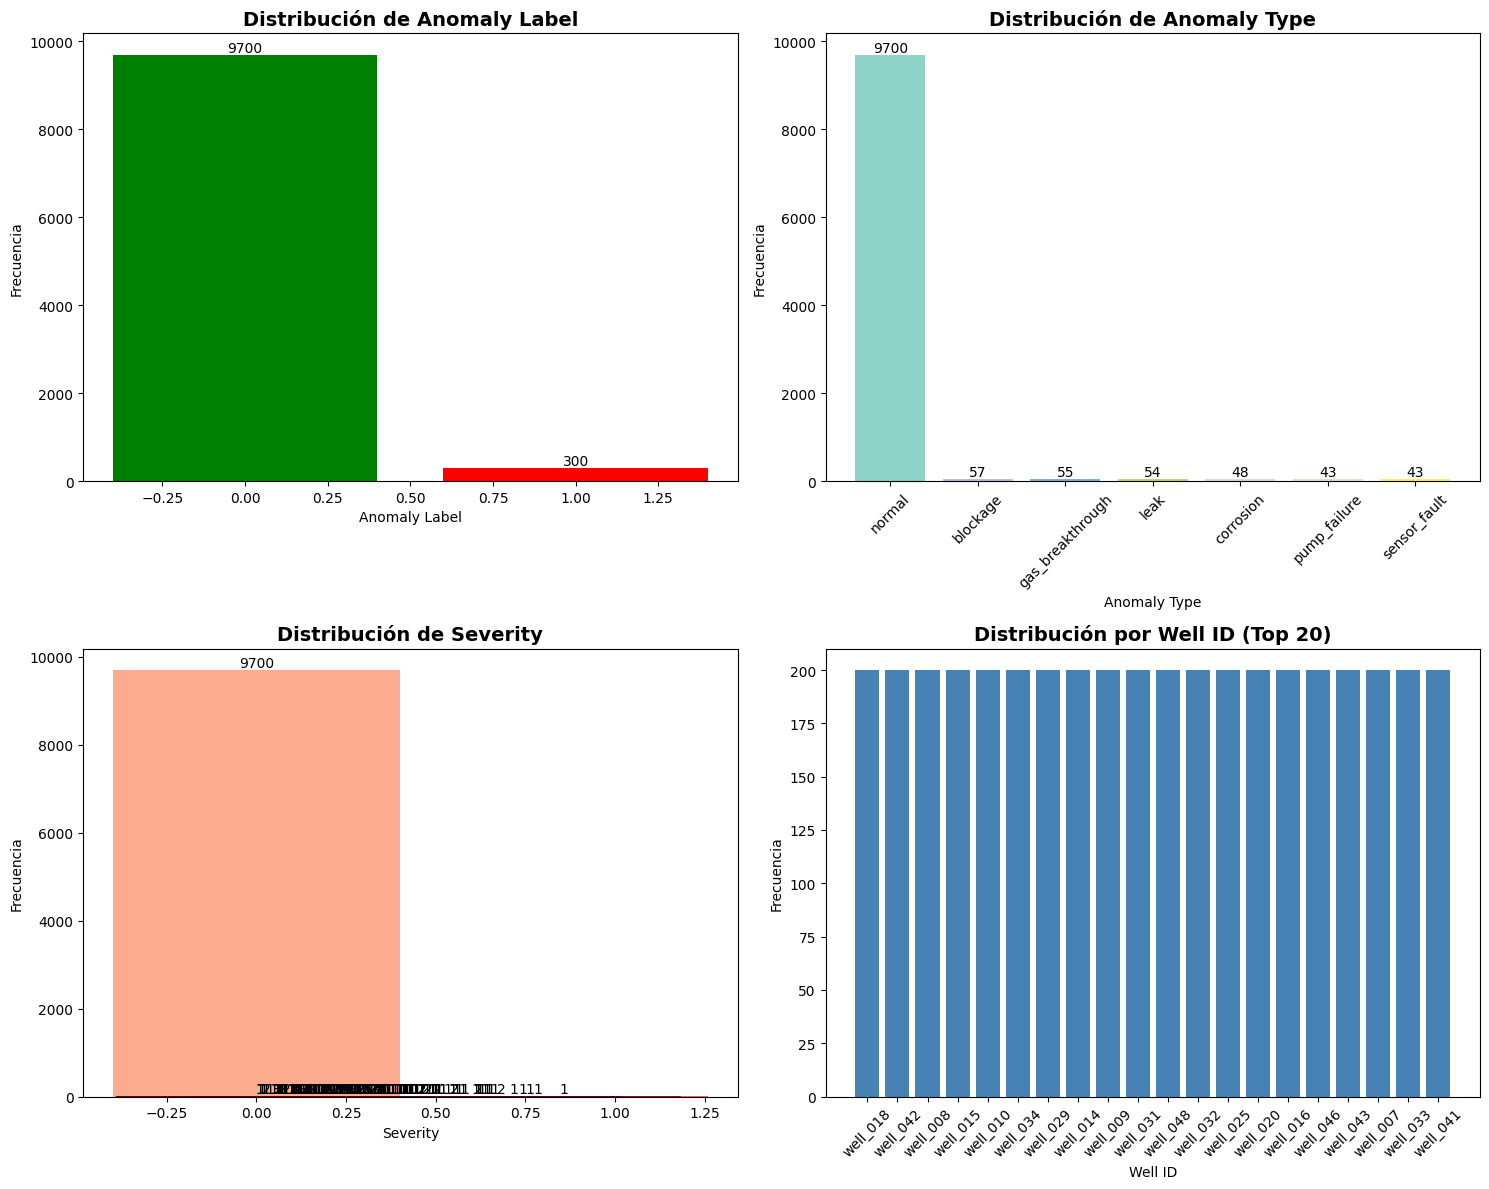

ANÁLISIS DE ANOMALÍAS POR POZO:
Top 10 pozos con mayor tasa de anomalías:
          Total_Readings  Anomalies  Anomaly_Rate
well_id                                          
well_011             200         10         0.050
well_006             200         10         0.050
well_016             200         10         0.050
well_026             200         10         0.050
well_012             200          9         0.045
well_002             200          9         0.045
well_021             200          9         0.045
well_025             200          9         0.045
well_014             200          8         0.040
well_017             200          8         0.040


In [10]:
# Visualización de la distribución de anomalías
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de anomaly_label
anomaly_counts = df['anomaly_label'].value_counts()
axes[0,0].bar(anomaly_counts.index, anomaly_counts.values, color=['green', 'red'])
axes[0,0].set_title('Distribución de Anomaly Label', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Anomaly Label')
axes[0,0].set_ylabel('Frecuencia')
for i, v in enumerate(anomaly_counts.values):
    axes[0,0].text(i, v, str(v), ha='center', va='bottom')

# 2. Distribución de anomaly_type
anomaly_type_counts = df['anomaly_type'].value_counts()
axes[0,1].bar(range(len(anomaly_type_counts)), anomaly_type_counts.values, 
              color=plt.cm.Set3(np.linspace(0, 1, len(anomaly_type_counts))))
axes[0,1].set_title('Distribución de Anomaly Type', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Anomaly Type')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_xticks(range(len(anomaly_type_counts)))
axes[0,1].set_xticklabels(anomaly_type_counts.index, rotation=45)
for i, v in enumerate(anomaly_type_counts.values):
    axes[0,1].text(i, v, str(v), ha='center', va='bottom')

# 3. Distribución de severity
severity_counts = df['severity'].value_counts()
axes[1,0].bar(severity_counts.index, severity_counts.values, 
              color=plt.cm.Reds(np.linspace(0.3, 1, len(severity_counts))))
axes[1,0].set_title('Distribución de Severity', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Severity')
axes[1,0].set_ylabel('Frecuencia')
for i, v in enumerate(severity_counts.values):
    axes[1,0].text(severity_counts.index[i], v, str(v), ha='center', va='bottom')

# 4. Distribución por well_id
well_counts = df['well_id'].value_counts().head(20)
axes[1,1].bar(range(len(well_counts)), well_counts.values, color='steelblue')
axes[1,1].set_title('Distribución por Well ID (Top 20)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Well ID')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_xticks(range(len(well_counts)))
axes[1,1].set_xticklabels(well_counts.index, rotation=45)

plt.tight_layout()
plt.show()

# Análisis de anomalías por pozo
print("ANÁLISIS DE ANOMALÍAS POR POZO:")
print("=" * 50)
anomalies_by_well = df.groupby('well_id')['anomaly_label'].agg(['count', 'sum', 'mean']).round(3)
anomalies_by_well.columns = ['Total_Readings', 'Anomalies', 'Anomaly_Rate']
anomalies_by_well = anomalies_by_well.sort_values('Anomaly_Rate', ascending=False)
print("Top 10 pozos con mayor tasa de anomalías:")
print(anomalies_by_well.head(10))

## 3. Ingeniería de Features

Creamos variables derivadas relevantes para el dominio petrolero y preparamos los datos para clustering.

Features creados:
- flow_efficiency
- pressure_ratio
- gas_content_ratio
- production_index
- temp_differential
- pressure_psi_norm_by_well
- flow_rate_bpd_norm_by_well
- pump_speed_rpm_norm_by_well
- vibration_g_norm_by_well
- pressure_psi_rolling_mean
- pressure_psi_rolling_std
- flow_rate_bpd_rolling_mean
- flow_rate_bpd_rolling_std
- vibration_g_rolling_mean
- vibration_g_rolling_std
- pressure_psi_change
- flow_rate_bpd_change
- pump_speed_rpm_change
- vibration_g_change

Total de features nuevos: 19
Shape después de feature engineering: (10000, 41)


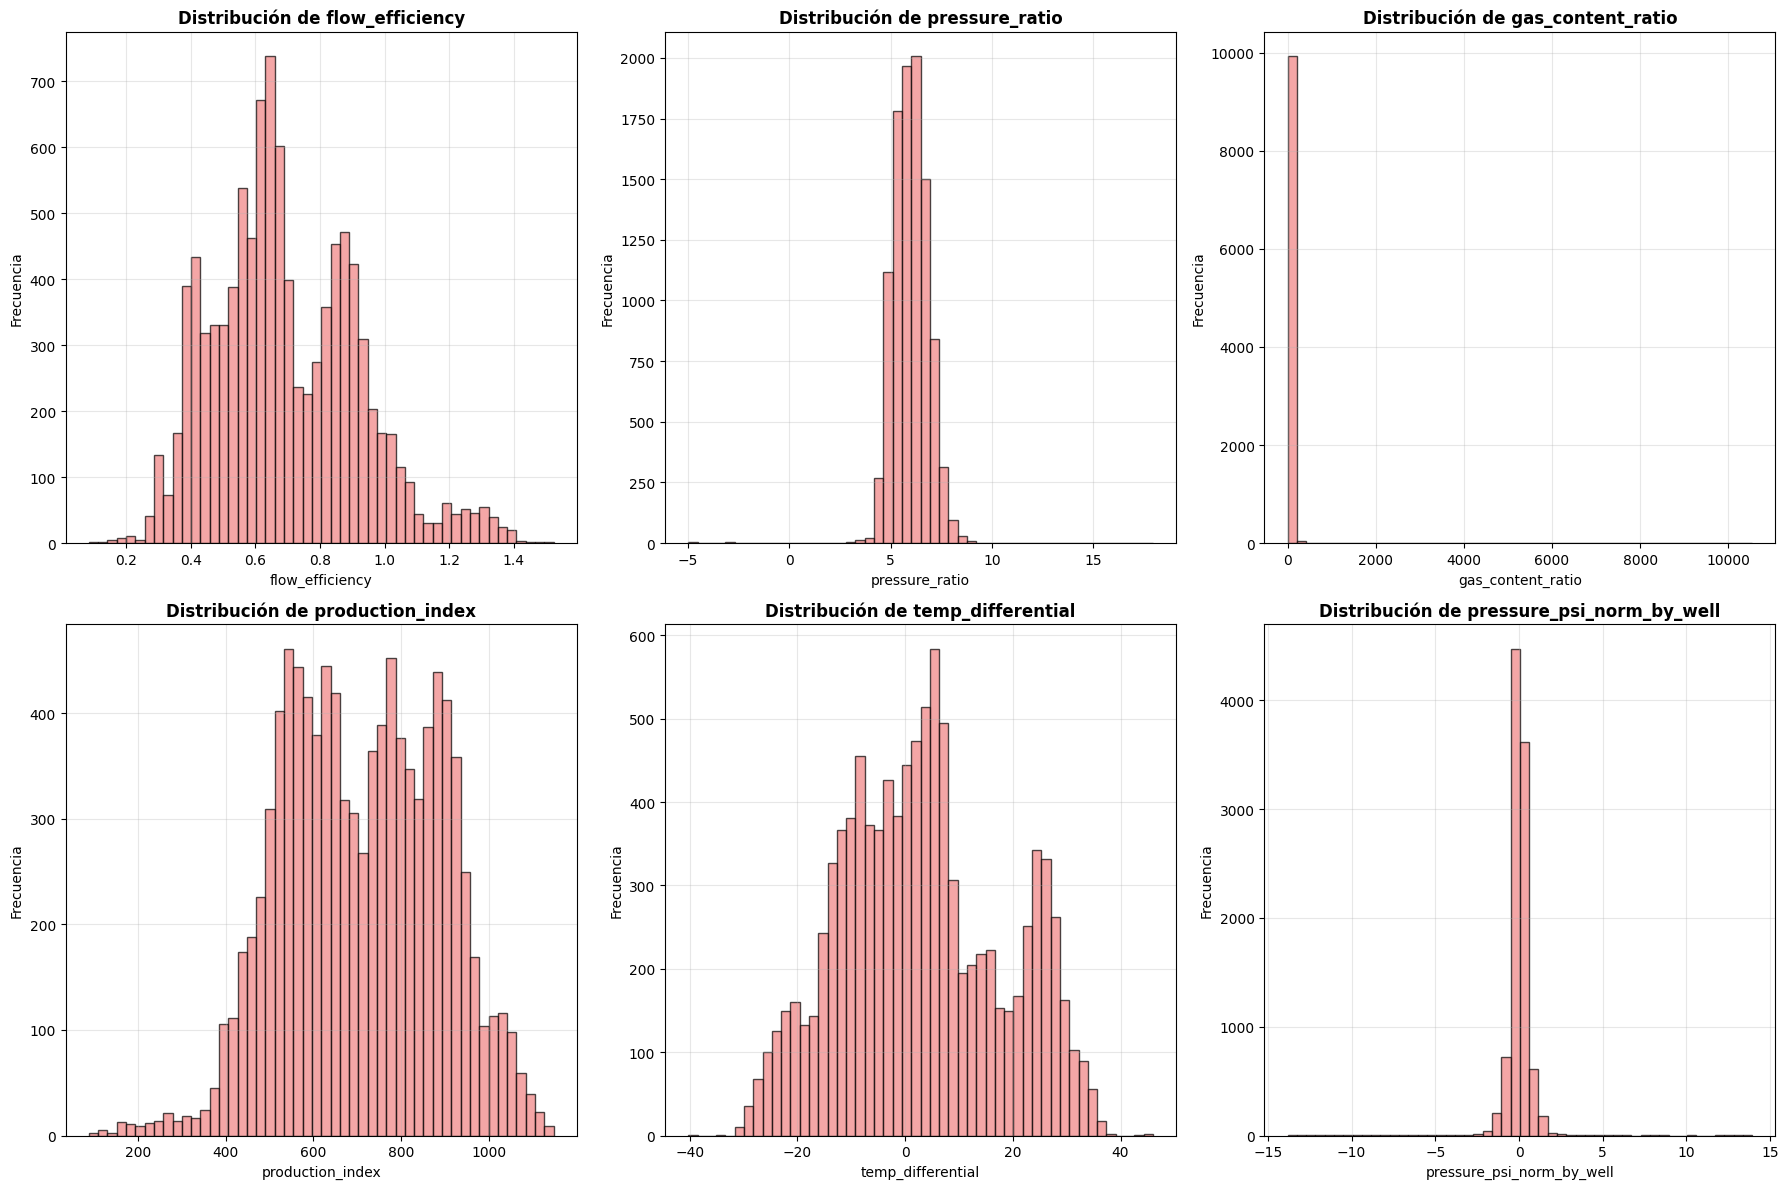

In [12]:
# Crear features derivados importantes para el dominio petrolero
df_fe = df.copy()

# 1. Ratios importantes en operaciones petroleras
df_fe['flow_efficiency'] = df_fe['flow_rate_bpd'] / (df_fe['pump_speed_rpm'] + 1e-6)  # Evitar división por 0
df_fe['pressure_ratio'] = df_fe['pressure_psi'] / (df_fe['annulus_pressure_psi'] + 1e-6)
df_fe['gas_content_ratio'] = df_fe['h2s_ppm'] / (df_fe['co2_pct'] + 1e-6)
df_fe['production_index'] = df_fe['oil_quality'] * df_fe['flow_rate_bpd']
df_fe['temp_differential'] = df_fe['temp_c'] - df_fe['tubing_temp_c']

# 2. Features normalizados por pozo (baseline por pozo)
well_baselines = df_fe.groupby('well_id')[numerical_vars].mean()
well_stds = df_fe.groupby('well_id')[numerical_vars].std()

# Crear features normalizados por pozo para variables clave
key_vars = ['pressure_psi', 'flow_rate_bpd', 'pump_speed_rpm', 'vibration_g']
for var in key_vars:
    # Normalización respecto al baseline del pozo
    df_fe[f'{var}_norm_by_well'] = df_fe.apply(
        lambda row: (row[var] - well_baselines.loc[row['well_id'], var]) / 
                   (well_stds.loc[row['well_id'], var] + 1e-6), axis=1
    )

# 3. Rolling features (ventana de 5 lecturas por pozo)
df_fe = df_fe.sort_values(['well_id', 'timestamp'])
rolling_vars = ['pressure_psi', 'flow_rate_bpd', 'vibration_g']
for var in rolling_vars:
    df_fe[f'{var}_rolling_mean'] = df_fe.groupby('well_id')[var].rolling(5, min_periods=1).mean().values
    df_fe[f'{var}_rolling_std'] = df_fe.groupby('well_id')[var].rolling(5, min_periods=1).std().fillna(0).values

# 4. Detección de cambios bruscos
for var in key_vars:
    df_fe[f'{var}_change'] = df_fe.groupby('well_id')[var].diff().fillna(0)

print("Features creados:")
new_features = [col for col in df_fe.columns if col not in df.columns]
for feat in new_features:
    print(f"- {feat}")

print(f"\nTotal de features nuevos: {len(new_features)}")
print(f"Shape después de feature engineering: {df_fe.shape}")

# Visualizar algunos features derivados
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

derived_features = ['flow_efficiency', 'pressure_ratio', 'gas_content_ratio', 
                   'production_index', 'temp_differential', 'pressure_psi_norm_by_well']

for i, feat in enumerate(derived_features):
    axes[i].hist(df_fe[feat], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[i].set_title(f'Distribución de {feat}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Preprocesado para Clustering

### 4.1 Selección de Features y Tratamiento de Outliers

In [13]:
# Seleccionar features finales para clustering
clustering_features = [
    'pressure_psi', 'temp_c', 'flow_rate_bpd', 'vibration_g', 'pump_speed_rpm',
    'oil_quality', 'gas_oil_ratio', 'h2s_ppm', 'co2_pct', 'delta_pressure_annulus',
    'flow_efficiency', 'pressure_ratio', 'production_index', 'temp_differential',
    'pressure_psi_norm_by_well', 'flow_rate_bpd_norm_by_well', 'vibration_g_norm_by_well'
]

# Crear dataset para clustering
X_raw = df_fe[clustering_features].copy()

print("Verificación de valores faltantes en features de clustering:")
print(X_raw.isnull().sum())

# Imputar valores faltantes con mediana
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X_raw), columns=X_raw.columns, index=X_raw.index)

# Análisis de outliers usando IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detección de outliers para cada variable
outlier_summary = []
for col in X_imputed.columns:
    outliers, lower, upper = detect_outliers_iqr(X_imputed, col)
    outlier_pct = (len(outliers) / len(X_imputed)) * 100
    outlier_summary.append({
        'Variable': col,
        'Outliers': len(outliers),
        'Porcentaje': outlier_pct,
        'Límite_Inferior': lower,
        'Límite_Superior': upper
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Porcentaje', ascending=False)
print("\nOutliers detectados por variable (método IQR):")
print(outlier_df.head(10))

# Aplicar winsorización para variables con muchos outliers (>10%)
from scipy.stats import mstats
X_processed = X_imputed.copy()

high_outlier_vars = outlier_df[outlier_df['Porcentaje'] > 10]['Variable'].tolist()
print(f"\nVariables con >10% outliers que se winzorizarán: {high_outlier_vars}")

for var in high_outlier_vars:
    X_processed[var] = mstats.winsorize(X_processed[var], limits=[0.01, 0.01])

# Escalado de datos
from sklearn.preprocessing import StandardScaler, RobustScaler

# Usar RobustScaler para ser menos sensible a outliers restantes
scaler_robust = RobustScaler()
X_scaled_robust = pd.DataFrame(
    scaler_robust.fit_transform(X_processed), 
    columns=X_processed.columns, 
    index=X_processed.index
)

# También preparar versión con StandardScaler para comparar
scaler_standard = StandardScaler()
X_scaled_standard = pd.DataFrame(
    scaler_standard.fit_transform(X_processed), 
    columns=X_processed.columns, 
    index=X_processed.index
)

print(f"\nShapes después del preprocesado:")
print(f"X_scaled_robust: {X_scaled_robust.shape}")
print(f"X_scaled_standard: {X_scaled_standard.shape}")

# Preparar labels para evaluación
y_true = df_fe['anomaly_label'].values

print(f"\nDistribución de labels verdaderos:")
print(f"Normal: {(y_true == 0).sum()} ({(y_true == 0).mean():.2%})")
print(f"Anomalía: {(y_true == 1).sum()} ({(y_true == 1).mean():.2%})")

Verificación de valores faltantes en features de clustering:
pressure_psi                  0
temp_c                        0
flow_rate_bpd                 0
vibration_g                   0
pump_speed_rpm                0
oil_quality                   0
gas_oil_ratio                 0
h2s_ppm                       0
co2_pct                       0
delta_pressure_annulus        0
flow_efficiency               0
pressure_ratio                0
production_index              0
temp_differential             0
pressure_psi_norm_by_well     0
flow_rate_bpd_norm_by_well    0
vibration_g_norm_by_well      0
dtype: int64

Outliers detectados por variable (método IQR):
                      Variable  Outliers  Porcentaje  Límite_Inferior  \
14   pressure_psi_norm_by_well      1033       10.33        -0.812097   
15  flow_rate_bpd_norm_by_well       346        3.46        -1.233993   
16    vibration_g_norm_by_well       340        3.40        -1.857122   
11              pressure_ratio        88  

## 5. Análisis de Clustering con K-Means

### 5.1 Selección del Número Óptimo de Clusters (k)

Evaluando diferentes valores de k para K-Means...
k=2: Inertia=88016.83, Silhouette=0.686
k=3: Inertia=79091.89, Silhouette=0.110
k=4: Inertia=73522.40, Silhouette=0.106
k=5: Inertia=69903.61, Silhouette=0.113
k=6: Inertia=66614.20, Silhouette=0.114
k=7: Inertia=63810.80, Silhouette=0.116
k=8: Inertia=61135.70, Silhouette=0.117
k=9: Inertia=58980.62, Silhouette=0.124
k=10: Inertia=57090.97, Silhouette=0.122
k=11: Inertia=54515.57, Silhouette=0.126
k=12: Inertia=52914.04, Silhouette=0.130
k=13: Inertia=51414.09, Silhouette=0.141
k=14: Inertia=50012.19, Silhouette=0.139
k=15: Inertia=48939.35, Silhouette=0.151


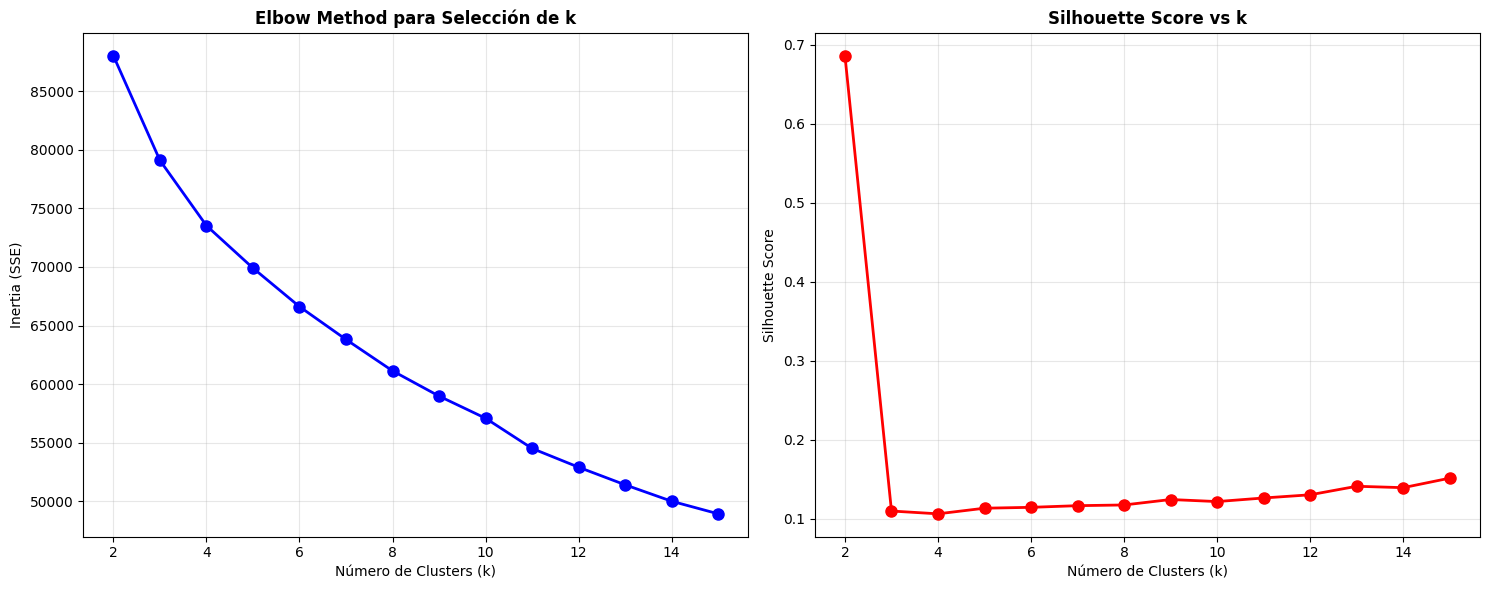


SELECCIÓN DE K ÓPTIMO
K óptimo (max silhouette): 2
Máximo Silhouette Score: 0.686

Top 3 valores de k por Silhouette Score:
     k  silhouette_score       inertia
0    2          0.686345  88016.826049
13  15          0.151331  48939.347830
11  13          0.141043  51414.090390


In [14]:
# Encontrar el número óptimo de clusters usando elbow method y silhouette score
k_range = range(2, 16)
inertias = []
silhouette_scores = []

print("Evaluando diferentes valores de k para K-Means...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_robust)
    inertias.append(kmeans.inertia_)
    
    # Calcular silhouette score
    sil_score = silhouette_score(X_scaled_robust, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

# Visualizar elbow method y silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inertia (SSE)')
ax1.set_title('Elbow Method para Selección de k', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs k', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar k óptimo (máximo silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)

print(f"\n" + "="*50)
print(f"SELECCIÓN DE K ÓPTIMO")
print(f"="*50)
print(f"K óptimo (max silhouette): {optimal_k}")
print(f"Máximo Silhouette Score: {max_silhouette:.3f}")

# También mostrar el top 3 de k por silhouette score
silhouette_df = pd.DataFrame({
    'k': k_range,
    'silhouette_score': silhouette_scores,
    'inertia': inertias
}).sort_values('silhouette_score', ascending=False)

print(f"\nTop 3 valores de k por Silhouette Score:")
print(silhouette_df.head(3))

### 5.2 Aplicación de K-Means y Análisis de Resultados

ANÁLISIS DE CLUSTERS - K-MEANS

Cluster 0:
  Tamaño: 9834 (98.3%)
  Anomalías: 134 (0.014)
  Tipos de anomalías: {'corrosion': 48, 'sensor_fault': 43, 'gas_breakthrough': 35, 'leak': 8}

Cluster 1:
  Tamaño: 166 (1.7%)
  Anomalías: 166 (1.000)
  Tipos de anomalías: {'blockage': 57, 'leak': 46, 'pump_failure': 43, 'gas_breakthrough': 20}

Threshold para anomalías (percentil 97): 4.708
Anomalías detectadas por K-Means: 300
Porcentaje de anomalías detectadas: 0.030

Varianza explicada por PCA: 0.444


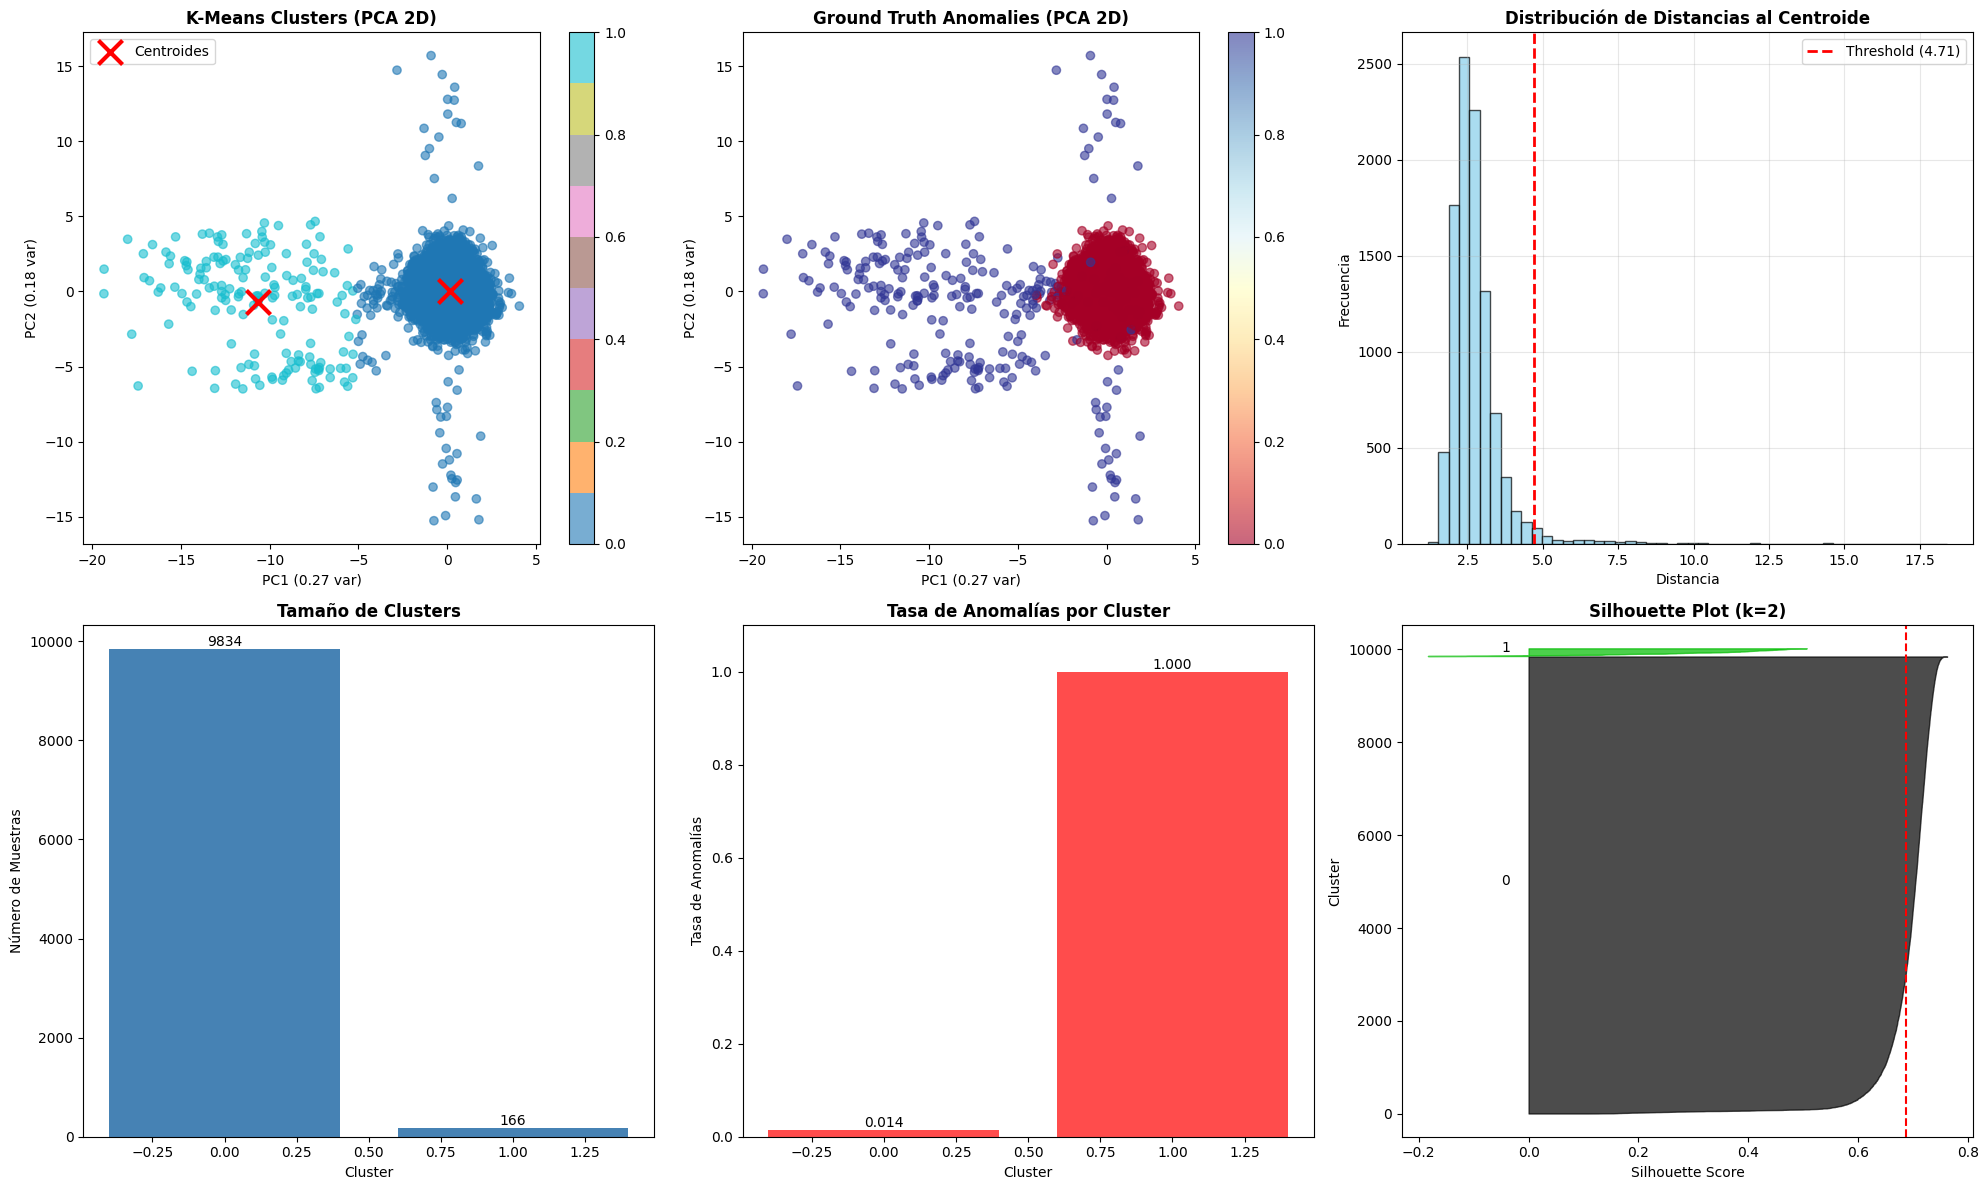

In [15]:
# Aplicar K-Means con el k óptimo
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled_robust)

# Agregar las etiquetas de cluster al dataset original
df_fe['kmeans_cluster'] = cluster_labels

# Análisis por cluster
print("ANÁLISIS DE CLUSTERS - K-MEANS")
print("=" * 50)
for i in range(optimal_k):
    cluster_data = df_fe[df_fe['kmeans_cluster'] == i]
    n_samples = len(cluster_data)
    n_anomalies = cluster_data['anomaly_label'].sum()
    anomaly_rate = n_anomalies / n_samples
    
    print(f"\nCluster {i}:")
    print(f"  Tamaño: {n_samples} ({n_samples/len(df_fe)*100:.1f}%)")
    print(f"  Anomalías: {n_anomalies} ({anomaly_rate:.3f})")
    
    # Distribución por tipo de anomalía
    if n_anomalies > 0:
        anomaly_types = cluster_data[cluster_data['anomaly_label'] == 1]['anomaly_type'].value_counts()
        print(f"  Tipos de anomalías: {anomaly_types.to_dict()}")

# Calcular distancias al centroide para detección de anomalías
distances = []
for i in range(len(X_scaled_robust)):
    cluster_id = cluster_labels[i]
    distance = np.linalg.norm(X_scaled_robust.iloc[i] - kmeans_final.cluster_centers_[cluster_id])
    distances.append(distance)

distances = np.array(distances)
df_fe['distance_to_centroid'] = distances

# Definir threshold para anomalías (percentil 97)
threshold = np.percentile(distances, 97)
df_fe['kmeans_anomaly'] = (distances > threshold).astype(int)

print(f"\nThreshold para anomalías (percentil 97): {threshold:.3f}")
print(f"Anomalías detectadas por K-Means: {df_fe['kmeans_anomaly'].sum()}")
print(f"Porcentaje de anomalías detectadas: {df_fe['kmeans_anomaly'].mean():.3f}")

# Reducción de dimensionalidad para visualización
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_robust)

print(f"\nVarianza explicada por PCA: {pca.explained_variance_ratio_.sum():.3f}")

# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. PCA scatter coloreado por cluster
scatter1 = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
axes[0,0].set_title('K-Means Clusters (PCA 2D)', fontweight='bold')
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')
plt.colorbar(scatter1, ax=axes[0,0])

# Agregar centroides transformados a PCA
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
axes[0,0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                 c='red', marker='x', s=300, linewidths=3, label='Centroides')
axes[0,0].legend()

# 2. PCA scatter coloreado por ground truth
scatter2 = axes[0,1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='RdYlBu', alpha=0.6)
axes[0,1].set_title('Ground Truth Anomalies (PCA 2D)', fontweight='bold')
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')
plt.colorbar(scatter2, ax=axes[0,1])

# 3. Distribución de distancias al centroide
axes[0,2].hist(distances, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,2].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.2f})')
axes[0,2].set_title('Distribución de Distancias al Centroide', fontweight='bold')
axes[0,2].set_xlabel('Distancia')
axes[0,2].set_ylabel('Frecuencia')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Tamaño de clusters
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
axes[1,0].bar(cluster_sizes.index, cluster_sizes.values, color='steelblue')
axes[1,0].set_title('Tamaño de Clusters', fontweight='bold')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Número de Muestras')
for i, v in enumerate(cluster_sizes.values):
    axes[1,0].text(i, v, str(v), ha='center', va='bottom')

# 5. Porcentaje de anomalías por cluster
anomaly_rates = []
for i in range(optimal_k):
    cluster_data = df_fe[df_fe['kmeans_cluster'] == i]
    rate = cluster_data['anomaly_label'].mean()
    anomaly_rates.append(rate)

axes[1,1].bar(range(optimal_k), anomaly_rates, color='red', alpha=0.7)
axes[1,1].set_title('Tasa de Anomalías por Cluster', fontweight='bold')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Tasa de Anomalías')
axes[1,1].set_ylim(0, max(anomaly_rates) * 1.1)
for i, v in enumerate(anomaly_rates):
    axes[1,1].text(i, v, f'{v:.3f}', ha='center', va='bottom')

# 6. Silhouette plot para el k elegido
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_scaled_robust, cluster_labels)
y_lower = 10
for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    axes[1,2].fill_betweenx(np.arange(y_lower, y_upper),
                           0, cluster_silhouette_vals,
                           facecolor=color, edgecolor=color, alpha=0.7)
    
    axes[1,2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1,2].axvline(x=silhouette_score(X_scaled_robust, cluster_labels), color="red", linestyle="--")
axes[1,2].set_title(f'Silhouette Plot (k={optimal_k})', fontweight='bold')
axes[1,2].set_xlabel('Silhouette Score')
axes[1,2].set_ylabel('Cluster')

plt.tight_layout()
plt.show()

In [16]:
# Métricas cuantitativas de evaluación de K-Means
print("MÉTRICAS DE EVALUACIÓN - K-MEANS")
print("=" * 50)

# Métricas de clustering
ari_kmeans = adjusted_rand_score(y_true, cluster_labels)
ami_kmeans = adjusted_mutual_info_score(y_true, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari_kmeans:.3f}")
print(f"Adjusted Mutual Information (AMI): {ami_kmeans:.3f}")

# Métricas de clasificación usando anomalías detectadas
y_pred_kmeans = df_fe['kmeans_anomaly'].values

print(f"\nMétricas de clasificación binaria (anomaly detection):")
print(f"Precision: {classification_report(y_true, y_pred_kmeans, output_dict=True)['1']['precision']:.3f}")
print(f"Recall: {classification_report(y_true, y_pred_kmeans, output_dict=True)['1']['recall']:.3f}")
print(f"F1-Score: {classification_report(y_true, y_pred_kmeans, output_dict=True)['1']['f1-score']:.3f}")

print(f"\nConfusion Matrix:")
cm_kmeans = confusion_matrix(y_true, y_pred_kmeans)
print(cm_kmeans)

# Análisis detallado de clusters con alta proporción de anomalías
print(f"\n" + "="*60)
print("ANÁLISIS DETALLADO DE CLUSTERS ANÓMALOS")
print("="*60)

for i in range(optimal_k):
    cluster_data = df_fe[df_fe['kmeans_cluster'] == i]
    anomaly_rate = cluster_data['anomaly_label'].mean()
    
    if anomaly_rate > 0.05:  # Clusters con más del 5% de anomalías
        print(f"\nCluster {i} (SOSPECHOSO - {anomaly_rate:.1%} anomalías):")
        print(f"  Tamaño: {len(cluster_data)}")
        
        # Estadísticas de variables clave en este cluster
        key_stats = cluster_data[['pressure_psi', 'flow_rate_bpd', 'vibration_g', 'h2s_ppm']].describe()
        print(f"  Estadísticas clave:")
        for var in key_stats.columns:
            print(f"    {var}: mean={key_stats.loc['mean', var]:.2f}, std={key_stats.loc['std', var]:.2f}")
        
        # Tipos de anomalías más comunes
        if cluster_data['anomaly_label'].sum() > 0:
            anomaly_types = cluster_data[cluster_data['anomaly_label'] == 1]['anomaly_type'].value_counts()
            print(f"  Tipos de anomalías más frecuentes: {anomaly_types.head(3).to_dict()}")

# Contingency table: Cluster vs Anomaly Type
print(f"\nTabla de contingencia: Cluster vs Tipo de Anomalía")
contingency = pd.crosstab(df_fe['kmeans_cluster'], df_fe['anomaly_type'], normalize='index') * 100
print(contingency.round(1))

MÉTRICAS DE EVALUACIÓN - K-MEANS
Adjusted Rand Index (ARI): 0.696
Adjusted Mutual Information (AMI): 0.582

Métricas de clasificación binaria (anomaly detection):
Precision: 0.730
Recall: 0.730
F1-Score: 0.730

Confusion Matrix:
[[9619   81]
 [  81  219]]

ANÁLISIS DETALLADO DE CLUSTERS ANÓMALOS

Cluster 1 (SOSPECHOSO - 100.0% anomalías):
  Tamaño: 166
  Estadísticas clave:
    pressure_psi: mean=292.50, std=60.64
    flow_rate_bpd: mean=426.70, std=160.23
    vibration_g: mean=2.73, std=1.43
    h2s_ppm: mean=42.45, std=22.12
  Tipos de anomalías más frecuentes: {'blockage': 57, 'leak': 46, 'pump_failure': 43}

Tabla de contingencia: Cluster vs Tipo de Anomalía
anomaly_type    blockage  corrosion  gas_breakthrough  leak  normal  \
kmeans_cluster                                                        
0                    0.0        0.5               0.4   0.1    98.6   
1                   34.3        0.0              12.0  27.7     0.0   

anomaly_type    pump_failure  sensor_fault  

## 6. Análisis de Clustering con DBSCAN

### 6.1 Selección de Parámetros eps y min_samples

Reducción dimensional para DBSCAN:
Dimensiones originales: 17
Dimensiones reducidas: 8
Varianza explicada total: 0.875


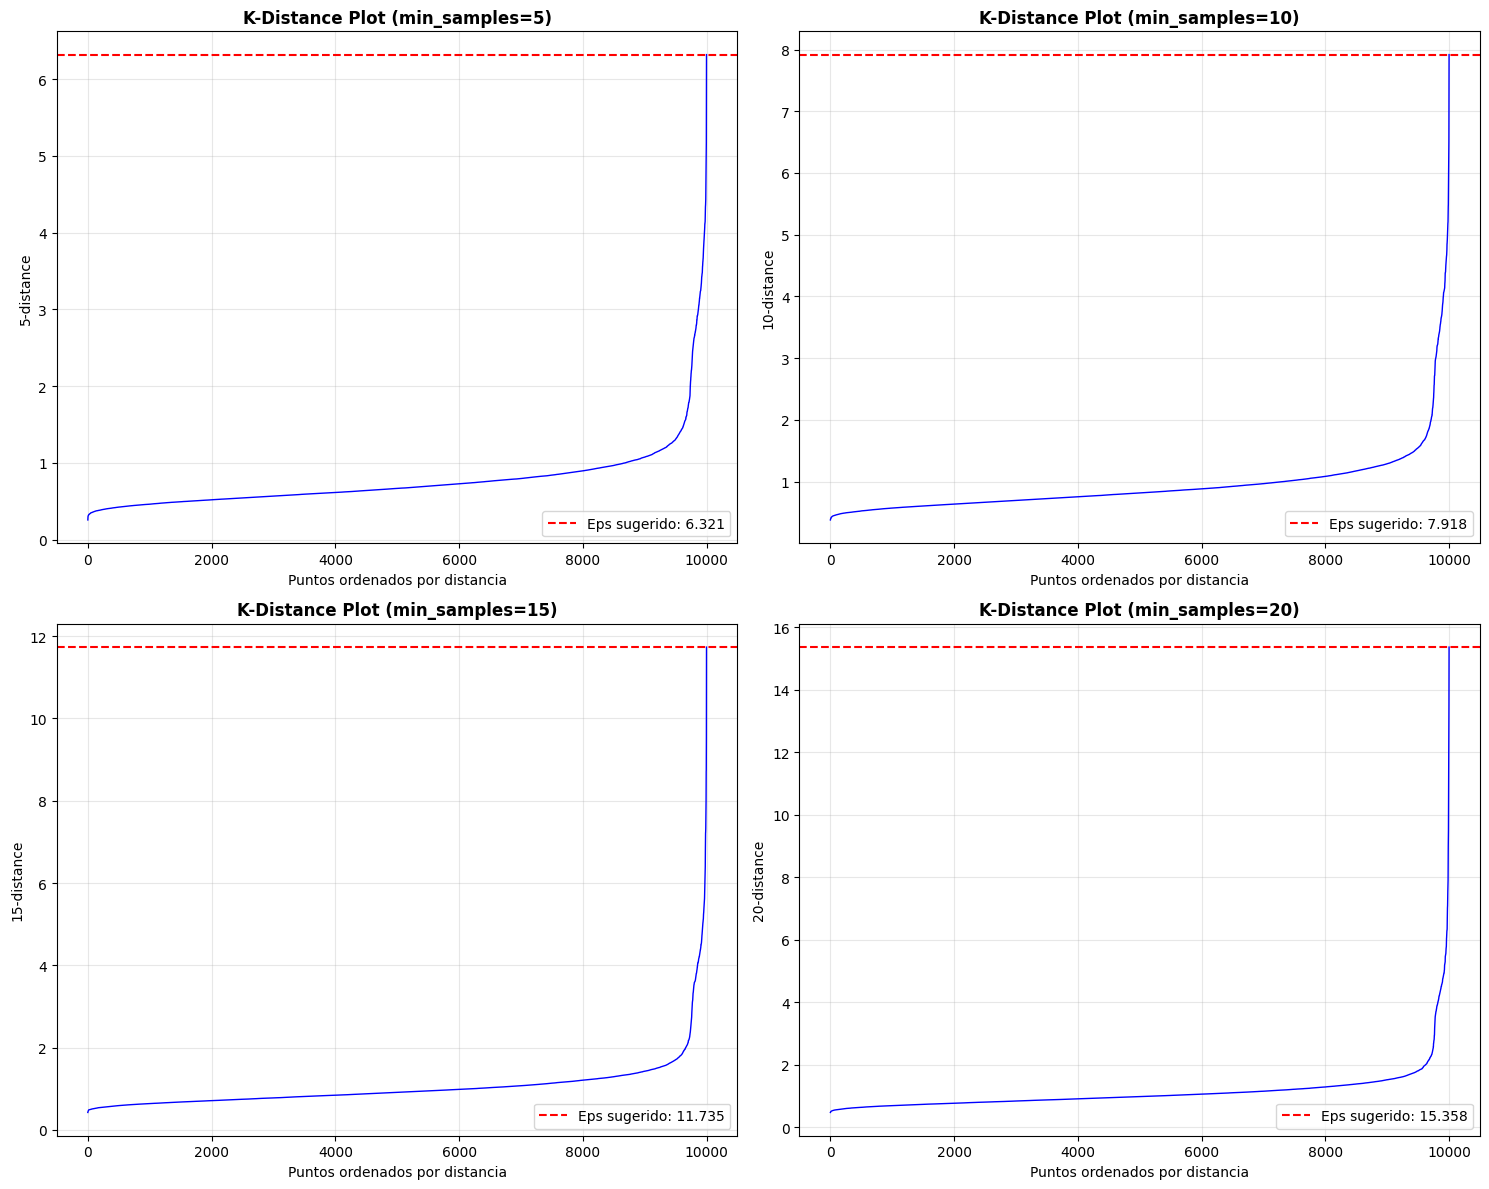

Sugerencias de eps para diferentes min_samples:
  min_samples=5: eps≈6.321
  min_samples=10: eps≈7.918
  min_samples=15: eps≈11.735
  min_samples=20: eps≈15.358

Parámetros a probar para DBSCAN:
  Configuración 1: min_samples=10, eps=7.918
  Configuración 2: min_samples=15, eps=11.735
  Configuración 3: min_samples=20, eps=15.358


In [17]:
# Preparar datos para DBSCAN - reducir dimensionalidad para mejor rendimiento
# Usar PCA para reducir dimensiones y mejorar performance de DBSCAN
pca_dbscan = PCA(n_components=8, random_state=42)
X_pca_dbscan = pca_dbscan.fit_transform(X_scaled_robust)

print(f"Reducción dimensional para DBSCAN:")
print(f"Dimensiones originales: {X_scaled_robust.shape[1]}")
print(f"Dimensiones reducidas: {X_pca_dbscan.shape[1]}")
print(f"Varianza explicada total: {pca_dbscan.explained_variance_ratio_.sum():.3f}")

# Función para calcular k-distance plot (ayuda a seleccionar eps)
def k_distance_plot(X, k=5):
    """
    Calcula y plotea k-distance para selección de eps en DBSCAN
    """
    from sklearn.neighbors import NearestNeighbors
    
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    
    # Tomar distancia al k-ésimo vecino y ordenar
    k_distances = distances[:, k-1]
    k_distances_sorted = np.sort(k_distances)
    
    return k_distances_sorted

# Probar diferentes valores de min_samples
min_samples_options = [5, 10, 15, 20]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

eps_suggestions = []

for i, min_samples in enumerate(min_samples_options):
    k_dist = k_distance_plot(X_pca_dbscan, k=min_samples)
    
    axes[i].plot(range(len(k_dist)), k_dist, 'b-', linewidth=1)
    axes[i].set_title(f'K-Distance Plot (min_samples={min_samples})', fontweight='bold')
    axes[i].set_xlabel('Puntos ordenados por distancia')
    axes[i].set_ylabel(f'{min_samples}-distance')
    axes[i].grid(True, alpha=0.3)
    
    # Buscar "rodilla" aproximada (donde la pendiente cambia más)
    # Usar diferencia de segundo orden para encontrar punto de inflexión
    if len(k_dist) > 100:
        # Tomar una muestra para encontrar la rodilla
        sample_indices = np.linspace(0, len(k_dist)-1, min(1000, len(k_dist)), dtype=int)
        sample_distances = k_dist[sample_indices]
        
        # Calcular segunda derivada
        second_derivative = np.diff(sample_distances, 2)
        knee_idx = np.argmax(second_derivative) + 2  # +2 porque perdemos 2 puntos con diff
        
        if knee_idx < len(sample_distances):
            suggested_eps = sample_distances[knee_idx]
            eps_suggestions.append(suggested_eps)
            
            # Marcar punto sugerido
            axes[i].axhline(y=suggested_eps, color='red', linestyle='--', 
                           label=f'Eps sugerido: {suggested_eps:.3f}')
            axes[i].legend()
        else:
            eps_suggestions.append(k_dist[len(k_dist)//4])  # Fallback
    else:
        eps_suggestions.append(k_dist[len(k_dist)//4])  # Fallback

plt.tight_layout()
plt.show()

print("Sugerencias de eps para diferentes min_samples:")
for i, (min_samp, eps_sug) in enumerate(zip(min_samples_options, eps_suggestions)):
    print(f"  min_samples={min_samp}: eps≈{eps_sug:.3f}")

# Seleccionar parámetros para experimentar
# Basándose en las sugerencias, probar algunas combinaciones
dbscan_params = [
    {'min_samples': 10, 'eps': eps_suggestions[1]},
    {'min_samples': 15, 'eps': eps_suggestions[2]},
    {'min_samples': 20, 'eps': eps_suggestions[3]}
]

print(f"\nParámetros a probar para DBSCAN:")
for i, params in enumerate(dbscan_params):
    print(f"  Configuración {i+1}: min_samples={params['min_samples']}, eps={params['eps']:.3f}")

### 6.2 Aplicación de DBSCAN y Análisis de Resultados

PROBANDO CONFIGURACIONES DE DBSCAN

Configuración 1: min_samples=10, eps=7.918
  Clusters encontrados: 1
  Puntos de ruido: 0 (0.0%)
  Silhouette Score: -1.000
  ARI: -1.000
  AMI: -1.000

Configuración 2: min_samples=15, eps=11.735
  Clusters encontrados: 1
  Puntos de ruido: 0 (0.0%)
  Silhouette Score: -1.000
  ARI: -1.000
  AMI: -1.000

Configuración 3: min_samples=20, eps=15.358
  Clusters encontrados: 1
  Puntos de ruido: 0 (0.0%)
  Silhouette Score: -1.000
  ARI: -1.000
  AMI: -1.000

MEJOR CONFIGURACIÓN DBSCAN
Configuración 1: eps=7.918, min_samples=10
ARI: -1.000

ANÁLISIS DETALLADO - DBSCAN

Cluster 0:
  Tamaño: 10000 (100.0%)
  Anomalías: 300 (0.030)
  Tipos de anomalías: {'blockage': 57, 'gas_breakthrough': 55, 'leak': 54, 'corrosion': 48, 'pump_failure': 43, 'sensor_fault': 43}


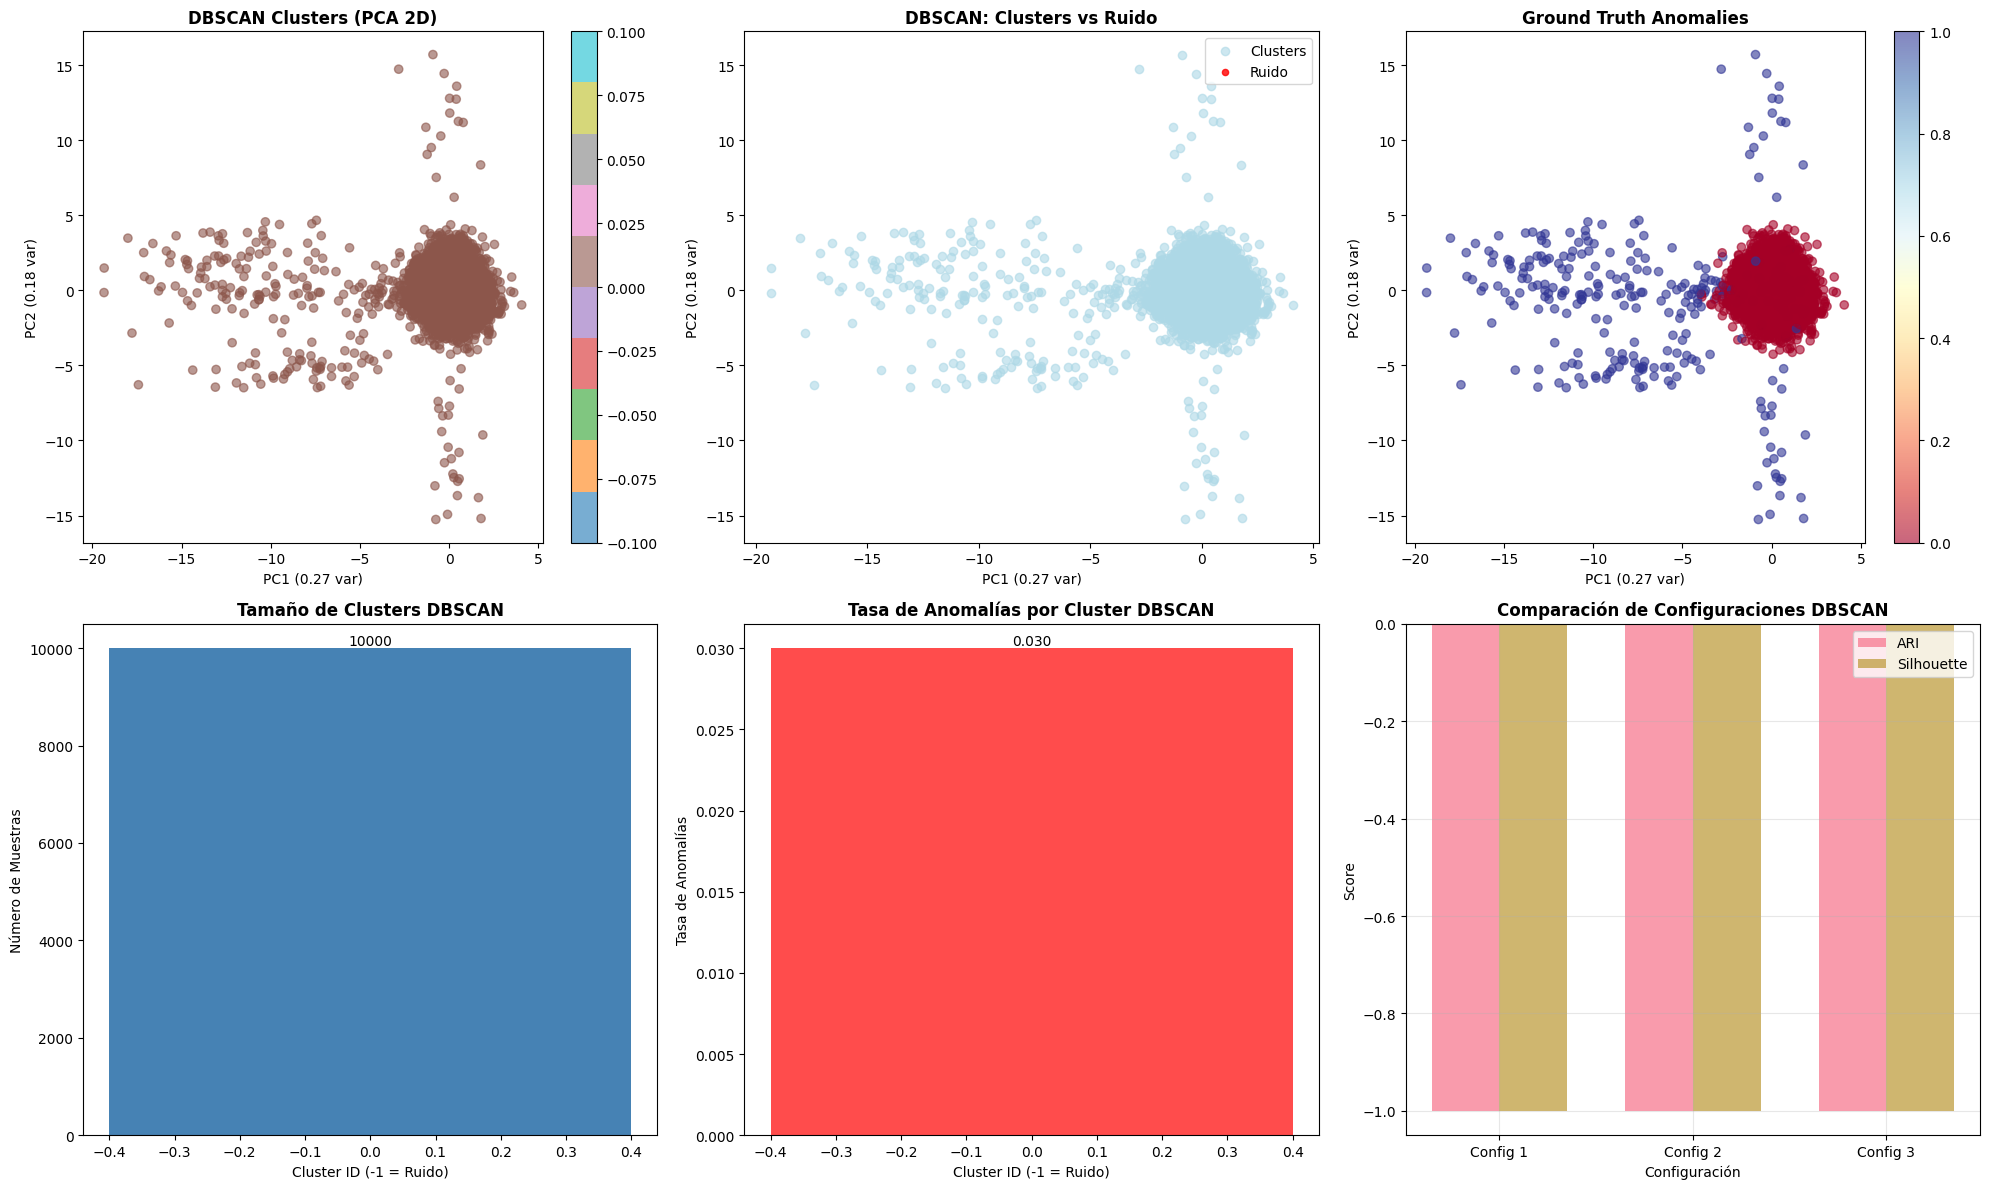


MÉTRICAS FINALES - DBSCAN
Adjusted Rand Index (ARI): -1.000
Adjusted Mutual Information (AMI): -1.000

Métricas de clasificación binaria (anomaly detection):
Precision: 0.000
Recall: 0.000
F1-Score: 0.000

Confusion Matrix:
[[9700    0]
 [ 300    0]]

Tabla de contingencia: DBSCAN Cluster vs Tipo de Anomalía
anomaly_type    blockage  corrosion  gas_breakthrough  leak  normal  \
dbscan_cluster                                                        
0                    0.6        0.5               0.5   0.5    97.0   

anomaly_type    pump_failure  sensor_fault  
dbscan_cluster                              
0                        0.4           0.4  


In [18]:
# Probar las diferentes configuraciones de DBSCAN
dbscan_results = []

print("PROBANDO CONFIGURACIONES DE DBSCAN")
print("=" * 50)

for i, params in enumerate(dbscan_params):
    print(f"\nConfiguración {i+1}: min_samples={params['min_samples']}, eps={params['eps']:.3f}")
    
    # Aplicar DBSCAN
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    dbscan_labels = dbscan.fit_predict(X_pca_dbscan)
    
    # Calcular métricas
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    noise_percentage = n_noise / len(dbscan_labels)
    
    # Métricas de clustering
    if n_clusters > 1:
        # Para silhouette score, excluir ruido
        mask = dbscan_labels != -1
        if mask.sum() > 0:
            silhouette = silhouette_score(X_pca_dbscan[mask], dbscan_labels[mask])
        else:
            silhouette = -1
        
        ari = adjusted_rand_score(y_true, dbscan_labels)
        ami = adjusted_mutual_info_score(y_true, dbscan_labels)
    else:
        silhouette = -1
        ari = -1
        ami = -1
    
    result = {
        'config': i+1,
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percentage': noise_percentage,
        'silhouette': silhouette,
        'ari': ari,
        'ami': ami,
        'labels': dbscan_labels
    }
    
    dbscan_results.append(result)
    
    print(f"  Clusters encontrados: {n_clusters}")
    print(f"  Puntos de ruido: {n_noise} ({noise_percentage:.1%})")
    print(f"  Silhouette Score: {silhouette:.3f}")
    print(f"  ARI: {ari:.3f}")
    print(f"  AMI: {ami:.3f}")

# Seleccionar la mejor configuración
best_config = max(dbscan_results, key=lambda x: x['ari'] if x['ari'] > 0 else -1)
print(f"\n" + "="*50)
print(f"MEJOR CONFIGURACIÓN DBSCAN")
print(f"="*50)
print(f"Configuración {best_config['config']}: eps={best_config['eps']:.3f}, min_samples={best_config['min_samples']}")
print(f"ARI: {best_config['ari']:.3f}")

# Usar la mejor configuración para análisis detallado
best_labels = best_config['labels']
df_fe['dbscan_cluster'] = best_labels
df_fe['dbscan_anomaly'] = (best_labels == -1).astype(int)

# Análisis por cluster DBSCAN
print(f"\nANÁLISIS DETALLADO - DBSCAN")
print("=" * 50)

# Análisis del ruido
noise_data = df_fe[df_fe['dbscan_cluster'] == -1]
if len(noise_data) > 0:
    noise_anomaly_rate = noise_data['anomaly_label'].mean()
    print(f"\nRUIDO (Cluster -1):")
    print(f"  Tamaño: {len(noise_data)} ({len(noise_data)/len(df_fe)*100:.1f}%)")
    print(f"  Anomalías: {noise_data['anomaly_label'].sum()} ({noise_anomaly_rate:.3f})")
    if noise_data['anomaly_label'].sum() > 0:
        noise_anomaly_types = noise_data[noise_data['anomaly_label'] == 1]['anomaly_type'].value_counts()
        print(f"  Tipos de anomalías: {noise_anomaly_types.to_dict()}")

# Análisis de clusters válidos
for cluster_id in sorted(set(best_labels)):
    if cluster_id != -1:
        cluster_data = df_fe[df_fe['dbscan_cluster'] == cluster_id]
        n_samples = len(cluster_data)
        n_anomalies = cluster_data['anomaly_label'].sum()
        anomaly_rate = n_anomalies / n_samples if n_samples > 0 else 0
        
        print(f"\nCluster {cluster_id}:")
        print(f"  Tamaño: {n_samples} ({n_samples/len(df_fe)*100:.1f}%)")
        print(f"  Anomalías: {n_anomalies} ({anomaly_rate:.3f})")
        
        if n_anomalies > 0:
            anomaly_types = cluster_data[cluster_data['anomaly_label'] == 1]['anomaly_type'].value_counts()
            print(f"  Tipos de anomalías: {anomaly_types.to_dict()}")

# Visualizaciones para DBSCAN
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. PCA scatter coloreado por cluster DBSCAN
scatter1 = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='tab10', alpha=0.6)
axes[0,0].set_title('DBSCAN Clusters (PCA 2D)', fontweight='bold')
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')
plt.colorbar(scatter1, ax=axes[0,0])

# 2. PCA scatter destacando ruido
noise_mask = best_labels == -1
axes[0,1].scatter(X_pca[~noise_mask, 0], X_pca[~noise_mask, 1], c='lightblue', alpha=0.6, label='Clusters')
axes[0,1].scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], c='red', alpha=0.8, label='Ruido', s=20)
axes[0,1].set_title('DBSCAN: Clusters vs Ruido', fontweight='bold')
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')
axes[0,1].legend()

# 3. Comparación con ground truth
scatter3 = axes[0,2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='RdYlBu', alpha=0.6)
axes[0,2].set_title('Ground Truth Anomalies', fontweight='bold')
axes[0,2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[0,2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')
plt.colorbar(scatter3, ax=axes[0,2])

# 4. Distribución de tamaños de cluster
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
axes[1,0].bar(cluster_counts.index, cluster_counts.values, color='steelblue')
axes[1,0].set_title('Tamaño de Clusters DBSCAN', fontweight='bold')
axes[1,0].set_xlabel('Cluster ID (-1 = Ruido)')
axes[1,0].set_ylabel('Número de Muestras')
for i, v in enumerate(cluster_counts.values):
    axes[1,0].text(cluster_counts.index[i], v, str(v), ha='center', va='bottom')

# 5. Tasa de anomalías por cluster
cluster_anomaly_rates = []
cluster_ids = sorted(set(best_labels))
for cluster_id in cluster_ids:
    cluster_data = df_fe[df_fe['dbscan_cluster'] == cluster_id]
    rate = cluster_data['anomaly_label'].mean()
    cluster_anomaly_rates.append(rate)

axes[1,1].bar(cluster_ids, cluster_anomaly_rates, color='red', alpha=0.7)
axes[1,1].set_title('Tasa de Anomalías por Cluster DBSCAN', fontweight='bold')
axes[1,1].set_xlabel('Cluster ID (-1 = Ruido)')
axes[1,1].set_ylabel('Tasa de Anomalías')
for i, v in enumerate(cluster_anomaly_rates):
    axes[1,1].text(cluster_ids[i], v, f'{v:.3f}', ha='center', va='bottom')

# 6. Comparación de métricas entre configuraciones
config_nums = [r['config'] for r in dbscan_results]
aris = [r['ari'] for r in dbscan_results]
silhouettes = [r['silhouette'] for r in dbscan_results]

x = np.arange(len(config_nums))
width = 0.35

axes[1,2].bar(x - width/2, aris, width, label='ARI', alpha=0.7)
axes[1,2].bar(x + width/2, silhouettes, width, label='Silhouette', alpha=0.7)
axes[1,2].set_title('Comparación de Configuraciones DBSCAN', fontweight='bold')
axes[1,2].set_xlabel('Configuración')
axes[1,2].set_ylabel('Score')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels([f'Config {c}' for c in config_nums])
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métricas finales de DBSCAN
print(f"\n" + "="*50)
print("MÉTRICAS FINALES - DBSCAN")
print("="*50)

y_pred_dbscan = df_fe['dbscan_anomaly'].values

print(f"Adjusted Rand Index (ARI): {best_config['ari']:.3f}")
print(f"Adjusted Mutual Information (AMI): {best_config['ami']:.3f}")
print(f"\nMétricas de clasificación binaria (anomaly detection):")
print(f"Precision: {classification_report(y_true, y_pred_dbscan, output_dict=True)['1']['precision']:.3f}")
print(f"Recall: {classification_report(y_true, y_pred_dbscan, output_dict=True)['1']['recall']:.3f}")
print(f"F1-Score: {classification_report(y_true, y_pred_dbscan, output_dict=True)['1']['f1-score']:.3f}")

print(f"\nConfusion Matrix:")
cm_dbscan = confusion_matrix(y_true, y_pred_dbscan)
print(cm_dbscan)

# Tabla de contingencia DBSCAN
print(f"\nTabla de contingencia: DBSCAN Cluster vs Tipo de Anomalía")
contingency_dbscan = pd.crosstab(df_fe['dbscan_cluster'], df_fe['anomaly_type'], normalize='index') * 100
print(contingency_dbscan.round(1))

## 7. Comparación de Métodos y Conclusiones

COMPARACIÓN FINAL DE MÉTODOS
    Método    ARI    AMI  Precision  Recall  F1-Score  Anomalías_Detectadas
0  K-Means  0.696  0.582       0.73    0.73      0.73                   300
1   DBSCAN -1.000 -1.000       0.00    0.00      0.00                     0


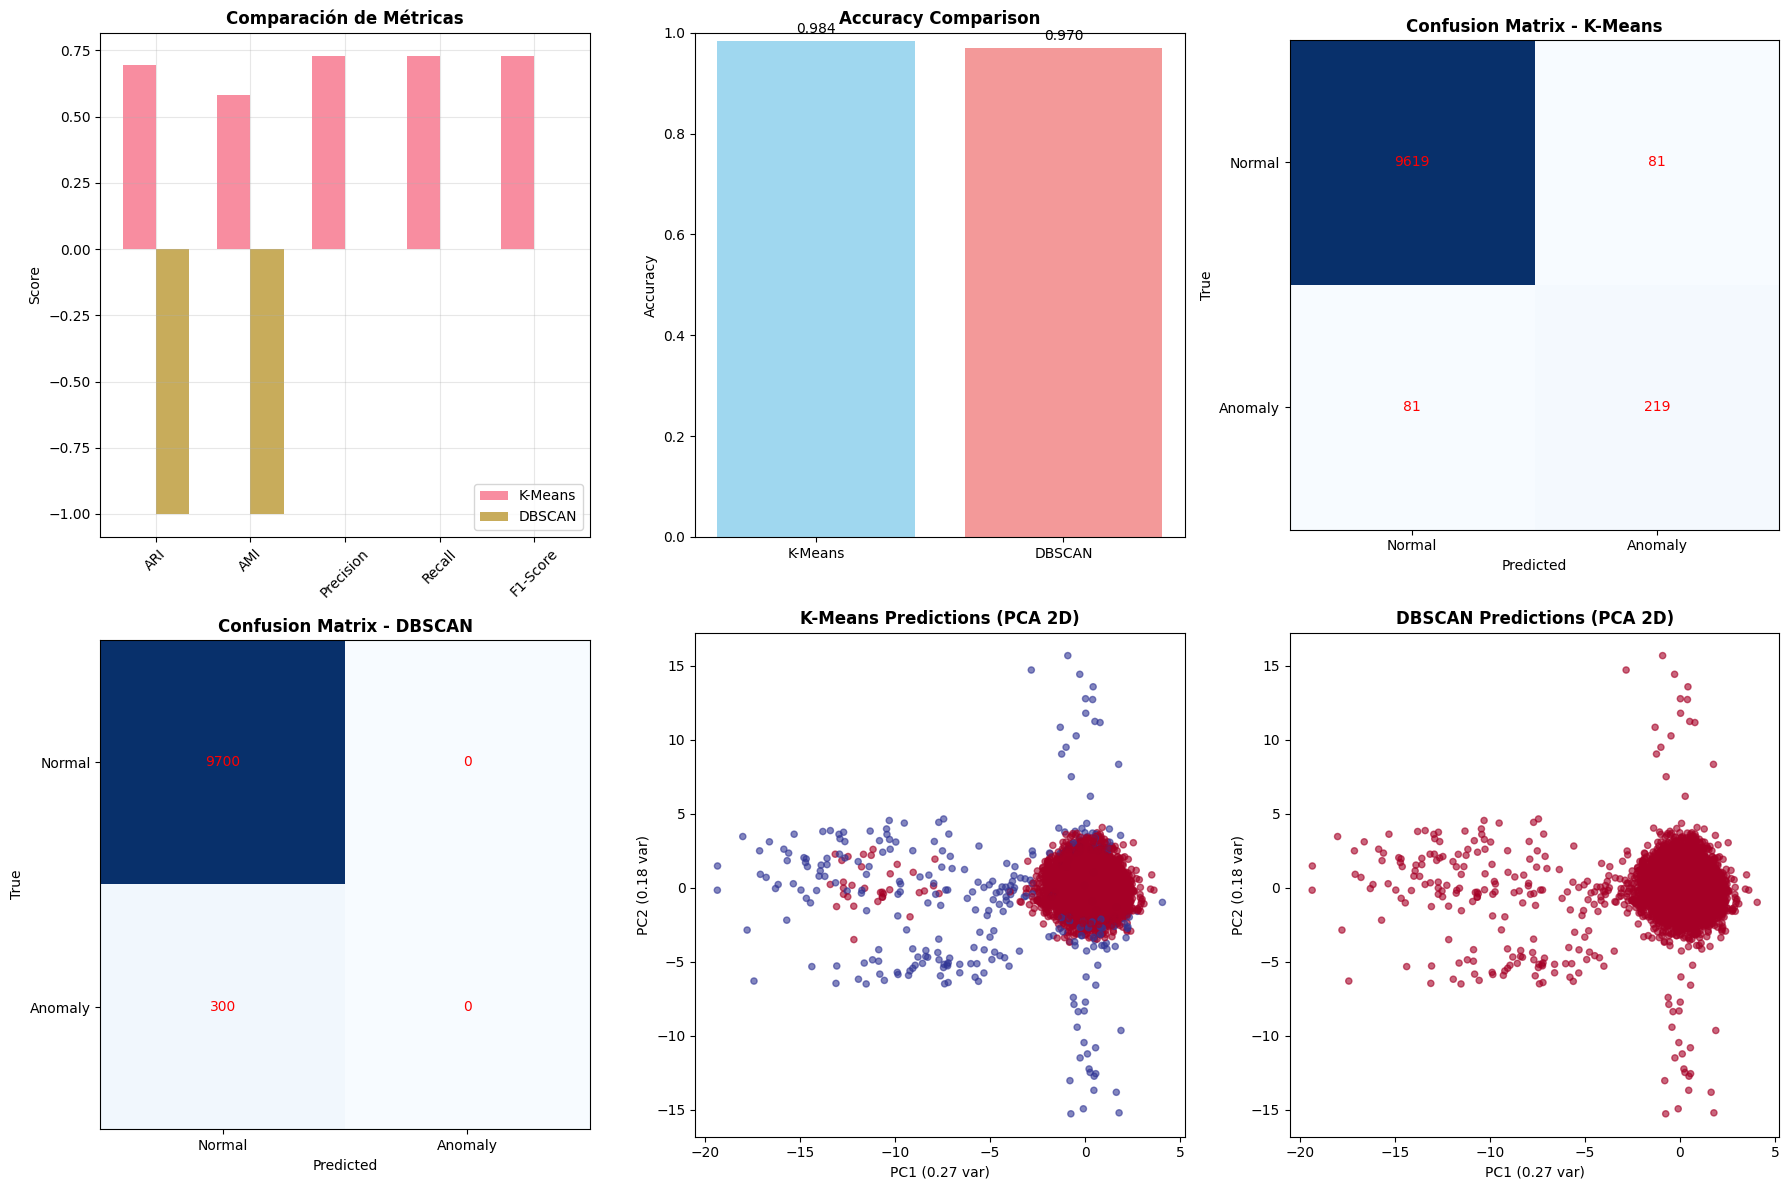


ANÁLISIS DE CONCORDANCIA ENTRE MÉTODOS
Contingencia K-Means vs DBSCAN:
col_0      0    All
row_0              
0       9700   9700
1        300    300
All    10000  10000

Casos donde difieren los métodos: 300 (3.0%)
Características de casos con desacuerdo:
  - Anomalías reales en casos de desacuerdo: 219
  - Tasa de anomalías reales: 0.730
  - Tipos de anomalías en desacuerdo: {'leak': 54, 'gas_breakthrough': 51, 'blockage': 47, 'sensor_fault': 42, 'pump_failure': 20, 'corrosion': 5}

CONCLUSIONES Y RECOMENDACIONES

RENDIMIENTO GENERAL:
- K-Means detectó 300 anomalías (3.0% del total)
- DBSCAN detectó 0 anomalías (0.0% del total)
- Anomalías reales en dataset: 300 (3.0% del total)

MÉTRICAS DE CLUSTERING:
- Mejor ARI: K-Means (0.696)
- Mejor AMI: K-Means (0.582)

MÉTRICAS DE DETECCIÓN DE ANOMALÍAS:
- Mejor Precision: K-Means
- Mejor Recall: K-Means
- Mejor F1-Score: K-Means

RECOMENDACIONES PARA EL DOMINIO PETROLERO:
1. K-Means es útil para identificar modos operacionales y clusters 

In [19]:
# Comparación final entre métodos
print("COMPARACIÓN FINAL DE MÉTODOS")
print("=" * 60)

# Recopilar métricas de ambos métodos
methods_comparison = {
    'Método': ['K-Means', 'DBSCAN'],
    'ARI': [ari_kmeans, best_config['ari']],
    'AMI': [ami_kmeans, best_config['ami']],
    'Precision': [
        classification_report(y_true, y_pred_kmeans, output_dict=True)['1']['precision'],
        classification_report(y_true, y_pred_dbscan, output_dict=True)['1']['precision']
    ],
    'Recall': [
        classification_report(y_true, y_pred_kmeans, output_dict=True)['1']['recall'],
        classification_report(y_true, y_pred_dbscan, output_dict=True)['1']['recall']
    ],
    'F1-Score': [
        classification_report(y_true, y_pred_kmeans, output_dict=True)['1']['f1-score'],
        classification_report(y_true, y_pred_dbscan, output_dict=True)['1']['f1-score']
    ],
    'Anomalías_Detectadas': [
        df_fe['kmeans_anomaly'].sum(),
        df_fe['dbscan_anomaly'].sum()
    ]
}

comparison_df = pd.DataFrame(methods_comparison)
print(comparison_df.round(3))

# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Comparación de métricas principales
metrics = ['ARI', 'AMI', 'Precision', 'Recall', 'F1-Score']
kmeans_values = [comparison_df.loc[0, metric] for metric in metrics]
dbscan_values = [comparison_df.loc[1, metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[0,0].bar(x - width/2, kmeans_values, width, label='K-Means', alpha=0.8)
axes[0,0].bar(x + width/2, dbscan_values, width, label='DBSCAN', alpha=0.8)
axes[0,0].set_title('Comparación de Métricas', fontweight='bold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(metrics, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distribución de predicciones vs ground truth
prediction_comparison = pd.DataFrame({
    'Ground_Truth': y_true,
    'K-Means': y_pred_kmeans,
    'DBSCAN': y_pred_dbscan
})

# Accuracy por método
kmeans_accuracy = (y_true == y_pred_kmeans).mean()
dbscan_accuracy = (y_true == y_pred_dbscan).mean()

axes[0,1].bar(['K-Means', 'DBSCAN'], [kmeans_accuracy, dbscan_accuracy], 
              color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0,1].set_title('Accuracy Comparison', fontweight='bold')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_ylim(0, 1)
for i, v in enumerate([kmeans_accuracy, dbscan_accuracy]):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 3. Matriz de confusión K-Means
im1 = axes[0,2].imshow(cm_kmeans, interpolation='nearest', cmap=plt.cm.Blues)
axes[0,2].set_title('Confusion Matrix - K-Means', fontweight='bold')
axes[0,2].set_xlabel('Predicted')
axes[0,2].set_ylabel('True')
axes[0,2].set_xticks([0, 1])
axes[0,2].set_yticks([0, 1])
axes[0,2].set_xticklabels(['Normal', 'Anomaly'])
axes[0,2].set_yticklabels(['Normal', 'Anomaly'])

# Agregar texto en la matriz de confusión
for i in range(2):
    for j in range(2):
        axes[0,2].text(j, i, str(cm_kmeans[i, j]), ha='center', va='center', color='red')

# 4. Matriz de confusión DBSCAN
im2 = axes[1,0].imshow(cm_dbscan, interpolation='nearest', cmap=plt.cm.Blues)
axes[1,0].set_title('Confusion Matrix - DBSCAN', fontweight='bold')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('True')
axes[1,0].set_xticks([0, 1])
axes[1,0].set_yticks([0, 1])
axes[1,0].set_xticklabels(['Normal', 'Anomaly'])
axes[1,0].set_yticklabels(['Normal', 'Anomaly'])

# Agregar texto en la matriz de confusión
for i in range(2):
    for j in range(2):
        axes[1,0].text(j, i, str(cm_dbscan[i, j]), ha='center', va='center', color='red')

# 5. Comparación visual en espacio PCA
axes[1,1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_kmeans, cmap='RdYlBu', alpha=0.6, s=20)
axes[1,1].set_title('K-Means Predictions (PCA 2D)', fontweight='bold')
axes[1,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[1,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')

axes[1,2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_dbscan, cmap='RdYlBu', alpha=0.6, s=20)
axes[1,2].set_title('DBSCAN Predictions (PCA 2D)', fontweight='bold')
axes[1,2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[1,2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')

plt.tight_layout()
plt.show()

# Análisis detallado de concordancia entre métodos
print("\n" + "="*60)
print("ANÁLISIS DE CONCORDANCIA ENTRE MÉTODOS")
print("="*60)

# Tabla de contingencia entre predicciones
contingency_methods = pd.crosstab(y_pred_kmeans, y_pred_dbscan, margins=True)
print("Contingencia K-Means vs DBSCAN:")
print(contingency_methods)

# Análisis de casos donde difieren
disagreement = (y_pred_kmeans != y_pred_dbscan)
print(f"\nCasos donde difieren los métodos: {disagreement.sum()} ({disagreement.mean():.1%})")

if disagreement.sum() > 0:
    disagreement_data = df_fe[disagreement]
    print(f"Características de casos con desacuerdo:")
    print(f"  - Anomalías reales en casos de desacuerdo: {disagreement_data['anomaly_label'].sum()}")
    print(f"  - Tasa de anomalías reales: {disagreement_data['anomaly_label'].mean():.3f}")
    
    # Tipos de anomalías en casos de desacuerdo
    if disagreement_data['anomaly_label'].sum() > 0:
        disagreement_anomaly_types = disagreement_data[disagreement_data['anomaly_label'] == 1]['anomaly_type'].value_counts()
        print(f"  - Tipos de anomalías en desacuerdo: {disagreement_anomaly_types.to_dict()}")

print("\n" + "="*60)
print("CONCLUSIONES Y RECOMENDACIONES")
print("="*60)

print(f"""
RENDIMIENTO GENERAL:
- K-Means detectó {df_fe['kmeans_anomaly'].sum()} anomalías ({df_fe['kmeans_anomaly'].mean():.1%} del total)
- DBSCAN detectó {df_fe['dbscan_anomaly'].sum()} anomalías ({df_fe['dbscan_anomaly'].mean():.1%} del total)
- Anomalías reales en dataset: {y_true.sum()} ({y_true.mean():.1%} del total)

MÉTRICAS DE CLUSTERING:
- Mejor ARI: {'K-Means' if ari_kmeans > best_config['ari'] else 'DBSCAN'} ({max(ari_kmeans, best_config['ari']):.3f})
- Mejor AMI: {'K-Means' if ami_kmeans > best_config['ami'] else 'DBSCAN'} ({max(ami_kmeans, best_config['ami']):.3f})

MÉTRICAS DE DETECCIÓN DE ANOMALÍAS:
- Mejor Precision: {'K-Means' if comparison_df.loc[0, 'Precision'] > comparison_df.loc[1, 'Precision'] else 'DBSCAN'}
- Mejor Recall: {'K-Means' if comparison_df.loc[0, 'Recall'] > comparison_df.loc[1, 'Recall'] else 'DBSCAN'}
- Mejor F1-Score: {'K-Means' if comparison_df.loc[0, 'F1-Score'] > comparison_df.loc[1, 'F1-Score'] else 'DBSCAN'}

RECOMENDACIONES PARA EL DOMINIO PETROLERO:
1. K-Means es útil para identificar modos operacionales y clusters sospechosos
2. DBSCAN es efectivo para detectar comportamientos de baja densidad (outliers)
3. Considerar ensemble: usar ambos métodos y combinar predicciones
4. Importante: feature engineering específico del dominio (ratios, deltas por pozo)
5. Monitoreo continuo: re-entrenar modelos periódicamente con nuevos datos
6. Validación con expertos de dominio para interpretar clusters operacionales
""")